# Import

## packages

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config IPCompleter.use_jedi = False

import pandas as pd
import numpy as np
import pickle
import os
from pathlib import Path
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import wilcoxon, kruskal
from statsmodels.stats.multitest import multipletests


warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'png'
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.dpi'] = 120
sns.set_style('ticks')

## functions

In [ ]:
from signature_validation.ssgsea_calc.ssgsea_calc import (
    read_gene_sets,
    detect_fges_source,
)
from signature_validation.utils.utils import (
    print_95ci_of_mean,
    to_common_samples,
    read_dataset,
    df_fisher_chi2,
    scale_series,
)


from signature_validation.plotting import (
    calculate_and_plot_correlations,
    default_cmap,
    boxplot_with_pvalue,
)

## data

In [ ]:
all_msigdb_gmt = read_gene_sets("./data/msigdb.v2023.1.Hs.symbols.gmt")

In [ ]:
p = Path("./data/")  # Sharing_by_request
with open(p / "mapping_ssgseas.pkl", "rb") as handle:
    mapping_ssgseas = pickle.load(handle)
for key in mapping_ssgseas.keys():
    for i in mapping_ssgseas[key]["Goi"].keys():
        print(key, "\t", i, "\t", mapping_ssgseas[key]["Goi"][i].shape)

Main4_Th1_signature 	 Th1_cells 	 (20, 65)
Main4_CD8_T_cells 	 CD8_T_cells 	 (453, 269)
Main4_Treg 	 Tregs 	 (73, 168)
Main4_Neutrophil_signature 	 Neutrophils 	 (199, 107)
Main4_Mast_cell_signature 	 Mast_cells 	 (51, 53)
Main4_Effector_cells 	 CD8_T_cells 	 (453, 386)
Main4_Effector_cells 	 NK_cells 	 (202, 386)
Main4_Eosinophil_signature 	 Eosinophils 	 (12, 39)
Main4_Follicular_helper_T_cells 	 Follicular_T_helper_tonsil 	 (24, 50)
Main4_B_cells 	 B_cells 	 (504, 378)
Main4_Endothelium 	 Endothelium 	 (322, 98)
Main4_Pan_macrophage_signature 	 Macrophages 	 (527, 261)
Main4_NK_cells 	 NK_cells 	 (202, 108)
Main4_M2_signature 	 Macrophages_M2 	 (23, 20)
Main4_T_cells 	 T_cells 	 (164, 155)
Main4_CD4_T_cells 	 CD4_T_cells 	 (1699, 423)
Main4_CD4_T_cells 	 CD4_T_helpers 	 (73, 423)
Main4_Lymphatic_endothelium 	 Endothelium_lymph 	 (89, 26)
Main4_Th17_signature 	 Th17_cells 	 (19, 54)
Main4_Plasma_cells 	 Plasma_B_cells 	 (11, 45)
Main4_Plasma_cells 	 Plasmablasts 	 (14, 45)
Main4_Mono

In [ ]:
with open(p / "msigdb_gmt.pkl", "rb") as handle:
    msigdb_gmt = pickle.load(handle)

In [ ]:
with open(p / "fges_metrics_controls_goi_wo_bootstrap.pkl", "rb") as handle:
    fges_metrics = pickle.load(handle)

In [ ]:
public_cells_annot = read_dataset(
    "/internal_data/public_cells_annot.tsv.gz"
)  # Sharing by request
public_cells_annot = public_cells_annot[~public_cells_annot.index.duplicated()]

In [21]:
ls = {}
for key in msigdb_gmt.keys():
    for fges in msigdb_gmt[key].keys():
        ls[fges] = len(msigdb_gmt[key][fges].genes)

<AxesSubplot:>

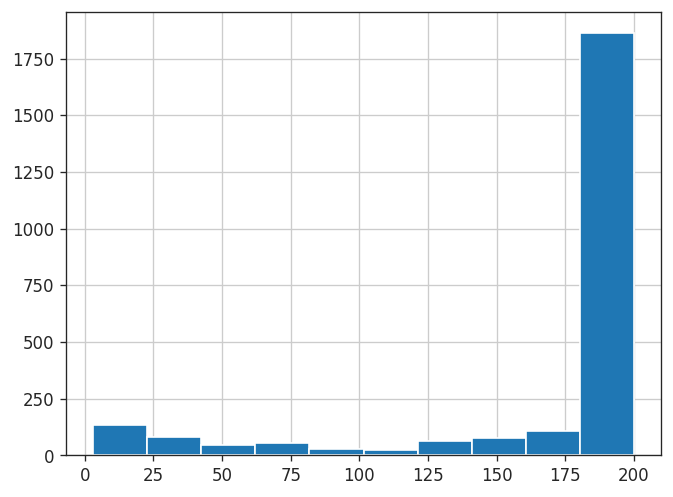

In [ ]:
pd.Series(ls).clip(0, 200).hist()

# Stat table

In [ ]:
other_sign_amount = {bg_sign: [] for bg_sign in msigdb_gmt.keys()}
msig_sign_amount = {bg_sign: [] for bg_sign in msigdb_gmt.keys()}
for bg_sign in msigdb_gmt.keys():
    goi = pd.concat(mapping_ssgseas[bg_sign]["Goi"].values())
    for name in goi.columns:
        source = detect_fges_source(name)
        if source not in ["Bindea", "Nirmal", "xCell", "Internal", "Random_FGES"]:
            msig_sign_amount[bg_sign].append(name)
        elif source in ["Bindea", "Nirmal", "xCell"]:
            other_sign_amount[bg_sign].append(name)

In [ ]:
other_sign_amount = pd.Series(
    {key: len(other_sign_amount[key]) for key in other_sign_amount.keys()}
)
msig_sign_amount = pd.Series(
    {key: len(msig_sign_amount[key]) for key in msig_sign_amount.keys()}
)

In [25]:
msig_sign_amount.sort_values()

Main4_M2_signature                   7
Main4_Lymphatic_endothelium         15
Main4_Eosinophil_signature          25
Main4_Plasma_cells                  30
Main4_Follicular_helper_T_cells     40
Main4_Mast_cell_signature           41
Main4_Th17_signature                44
Main4_Th1_signature                 52
Main4_Endothelium                   79
Main4_NK_cells                      89
Main4_Neutrophil_signature          89
Main4_T_cells                      129
Main4_Monocyte                     143
Main4_Treg                         155
Main4_Pan_macrophage_signature     238
Main4_CD8_T_cells                  253
Main4_B_cells                      347
Main4_Effector_cells               358
Main4_CD4_T_cells                  406
dtype: int64

In [ ]:
out = []
for bg_sign in msigdb_gmt.keys():
    goi = pd.concat(mapping_ssgseas[bg_sign]["Goi"].values())
    control = pd.concat(mapping_ssgseas[bg_sign]["Control"].values())
    signs = msigdb_gmt[bg_sign].keys()
    scores = pd.DataFrame({s: pd.DataFrame(fges_metrics[s]).T.mean() for s in signs}).T
    ind = scores.sort_values(
        by=["goi_cv", "F1", "control_cv"], ascending=[True, False, True]
    ).index
    goi_pv = {}
    control_pv = {}
    for comp_s in ind:
        if bg_sign != comp_s:
            x, y = to_common_samples((goi[bg_sign].dropna(), goi[comp_s].dropna()))
            _, pv = wilcoxon(x, y)
            goi_pv[comp_s] = pv
            x, y = to_common_samples(
                (control[bg_sign].dropna(), control[comp_s].dropna())
            )
            _, pv = wilcoxon(x, y)
            control_pv[comp_s] = pv
        else:
            goi_pv[comp_s] = 1
            control_pv[comp_s] = 1
    goi_pv = pd.Series(goi_pv)
    control_pv = pd.Series(control_pv)
    goi = goi[ind].mean()
    control = control[ind].mean()
    o = pd.DataFrame(
        {
            "GOI_Mean": goi,
            "GOI_p_adj_paired_wilcoxon": goi_pv,
            "Control_Mean": control,
            "Control_p_adj_paired_wilcoxon": control_pv,
            "F_score": scores["F1"].loc[ind],
            "Accuracy": scores["Accuracy"].loc[ind],
            "PR_AUC": scores["PR_AUC"].loc[ind],
            "ROC_AUC": scores["ROC_AUC"].loc[ind],
            "GOI_cv": scores["goi_cv"].loc[ind],
            "Control_cv": scores["control_cv"].loc[ind],
        }
    ).loc[ind]
    o["BG_FGES"] = [bg_sign for i in ind]
    o["Alt_FGES"] = ind
    o["FGES_source"] = o.Alt_FGES.map(lambda x: detect_fges_source(x))
    o["Genes"] = pd.Series(
        {
            k: ", ".join(list(msigdb_gmt[bg_sign][k].genes))
            for k in msigdb_gmt[bg_sign].keys()
        }
    )
    out.append(o)

In [46]:
out = pd.concat(out)

In [47]:
out.FGES_source.value_counts()

MSigDb_Dif_Expression           2209
Random_FGES                      190
MSigDb_Single_Cell               151
xCell                            117
Gene_Ontology                     79
MSigDb_Other                      29
Human_Phenotype_Ontology          23
Other                             19
WikiPathways                      18
Bindea                            12
Nirmal                             8
BioCarta                           4
KEGG                               4
Reactome                           3
Pathway_Interaction_Database       1
Name: FGES_source, dtype: int64

In [ ]:
mapper = {
    "Main4_Th1_signature": "Th1 cells",
    "Main4_CD8_T_cells": "CD8+ T cells",
    "Main4_Treg": "Tregs",
    "Main4_Neutrophil_signature": "Neutrophils",
    "Main4_Mast_cell_signature": "Mast_cells",
    "Main4_Effector_cells": "Effector cells",
    "Main4_Eosinophil_signature": "Eosinophils",
    "Main4_Follicular_helper_T_cells": "Follicular helper T cells",
    "Main4_B_cells": "B cells",
    "Main4_Endothelium": "Endothelial cells",
    "Main4_Pan_macrophage_signature": "Macrophages",
    "Main4_NK_cells": "NK cells",
    "Main4_M2_signature": "M2 Macrophages",
    "Main4_T_cells": "T cells",
    "Main4_CD4_T_cells": "CD4+ T cells",
    "Main4_Lymphatic_endothelium": "Lymphatic endothelial cells",
    "Main4_Th17_signature": "Th17 cells",
    "Main4_Plasma_cells": "Plasma B cells",
    "Main4_Monocyte": "Monocytes",
}
out["Supposed_GOI"] = out.BG_FGES.map(lambda x: mapper[x])

In [ ]:
mapper = {
    "Other": "Other",
    "MSigDb_Dif_Expression": "MSigDb_Dif_Expression",
    "xCell": "PMID: 29141660",
    "Random_FGES": "Random_FGES",
    "Gene_Ontology": "Gene_Ontology",
    "MSigDb_Other": "MSigDb_Other",
    "Bindea": "PMID: 24138885",
    "MSigDb_Single_Cell": "MSigDb_Single_Cell",
    "Human_Phenotype_Ontology": "Human_Phenotype_Ontology",
    "Reactome": "Reactome",
    "Nirmal": "PMID: 30266715",
    "BioCarta": "BioCarta",
    "Pathway_Interaction_Database": "Pathway_Interaction_Database",
    "KEGG": "KEGG",
    "WikiPathways": "WikiPathways",
}


out["Link"] = out.FGES_source.map(lambda x: mapper[x])

In [ ]:
out[["Supposed_GOI", "FGES_source", "Genes", "Link"]].to_csv(
    "sup1_table_public_fges_cell_types.tsv", sep="\t"
)

In [ ]:
for col in ["GOI_p_adj_paired_wilcoxon", "Control_p_adj_paired_wilcoxon"]:
    pv = out[col]
    _, pvals_corr, _, _ = multipletests(pv, method="fdr_bh")
    pvals_corr = pd.Series(data=pvals_corr, index=pv.index)
    out[col] = pvals_corr

In [ ]:
out = out.sort_values(by=["BG_FGES", "F_score"], ascending=[True, False])

In [ ]:
out.to_csv(p / f"fges_stats_table.tsv", sep="\t", index=False)

# See stats (for discussion)

In [15]:
out = out[~out.index.duplicated()]

In [ ]:
out.F_score[out.FGES_source == "Random_FGES"][out.F_score > 0.7].sort_values(
    ascending=False
)

RANDOM_FGES5_Main4_Lymphatic_endothelium         0.894698
RANDOM_FGES6_Main4_Plasma_cells                  0.857955
RANDOM_FGES7_Main4_Follicular_helper_T_cells     0.837880
RANDOM_FGES3_Main4_Eosinophil_signature          0.824584
RANDOM_FGES8_Main4_Monocyte                      0.815714
RANDOM_FGES9_Main4_CD8_T_cells                   0.812264
RANDOM_FGES9_Main4_Lymphatic_endothelium         0.795986
RANDOM_FGES5_Main4_Follicular_helper_T_cells     0.782901
RANDOM_FGES6_Main4_Follicular_helper_T_cells     0.765967
RANDOM_FGES3_Main4_Monocyte                      0.765739
RANDOM_FGES6_Main4_Eosinophil_signature          0.758688
RANDOM_FGES9_Main4_T_cells                       0.758549
RANDOM_FGES3_Main4_Follicular_helper_T_cells     0.758220
RANDOM_FGES7_Main4_CD4_T_cells                   0.754360
RANDOM_FGES10_Main4_Endothelium                  0.745992
RANDOM_FGES3_Main4_Lymphatic_endothelium         0.737328
RANDOM_FGES2_Main4_Eosinophil_signature          0.734427
RANDOM_FGES4_M

In [ ]:
out[out.BG_FGES == "Main4_Lymphatic_endothelium"].F_score.sort_values(ascending=False)

GOBP_LYMPH_VESSEL_DEVELOPMENT                     0.990062
Main4_Lymphatic_endothelium                       0.989476
CLASPER_LYMPHATIC_VESSELS_DURING_METASTASIS_UP    0.985969
HP_ABNORMAL_LYMPHATIC_VESSEL_MORPHOLOGY           0.984797
BINDEA_ET_AL_LYMPH_VESSEL                         0.931544
RANDOM_FGES5_Main4_Lymphatic_endothelium          0.894698
RANDOM_FGES9_Main4_Lymphatic_endothelium          0.795986
RANDOM_FGES3_Main4_Lymphatic_endothelium          0.737328
RANDOM_FGES4_Main4_Lymphatic_endothelium          0.675548
RANDOM_FGES1_Main4_Lymphatic_endothelium          0.637625
RANDOM_FGES6_Main4_Lymphatic_endothelium          0.606815
RANDOM_FGES2_Main4_Lymphatic_endothelium          0.591045
RANDOM_FGES7_Main4_Lymphatic_endothelium          0.585552
RANDOM_FGES10_Main4_Lymphatic_endothelium         0.520487
RANDOM_FGES8_Main4_Lymphatic_endothelium          0.351520
Name: F_score, dtype: float64

In [ ]:
cell_amount = {}
for bg_fges in out.BG_FGES.unique():
    cts = mapping_ssgseas[bg_fges]["Goi"].keys()
    cell_amount[bg_fges] = len(
        public_cells_annot.Cell_type[public_cells_annot.Cell_type.isin(cts)]
    )
cell_amount = pd.Series(cell_amount)

Pearson correlation: 0.1867, p-value: 4.4e-01
Spearman correlation: 0.1667, p-value: 5.0e-01
MSE: 248316.4057; MAE: 292.2305
R2: -0.5241
CCC: 0.0000
Number of samples: 19


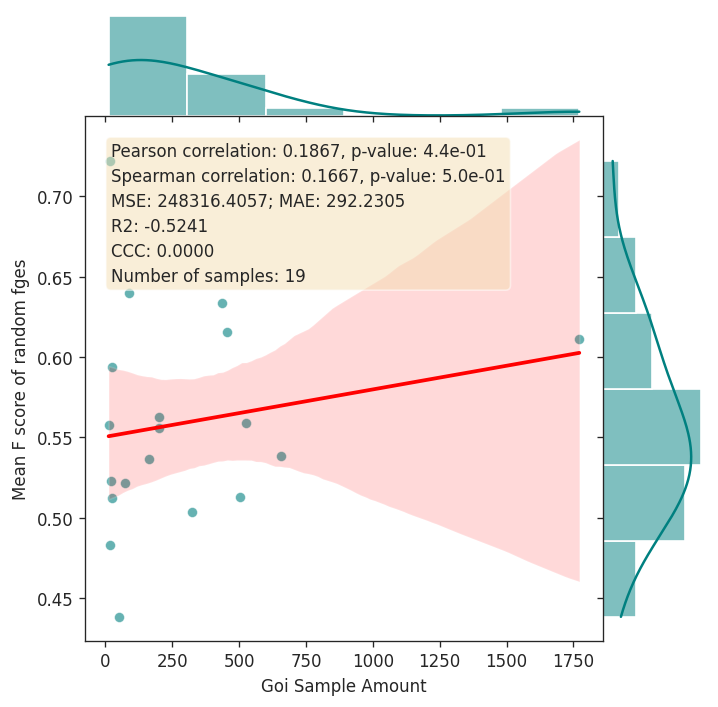

In [ ]:
random_fges_mean_f_score = (
    out.F_score[out.FGES_source == "Random_FGES"]
    .groupby(out.BG_FGES[out.FGES_source == "Random_FGES"])
    .mean()
    .sort_values(ascending=False)
)
calculate_and_plot_correlations(
    cell_amount,
    random_fges_mean_f_score,
    "Goi Sample Amount",
    "Mean F score of random fges",
)

In [ ]:
out.GOI_cv[out.FGES_source == "Random_FGES"].groupby(
    out.BG_FGES[out.FGES_source == "Random_FGES"]
).mean().sort_values(ascending=True)

BG_FGES
Main4_Eosinophil_signature         0.117254
Main4_Lymphatic_endothelium        0.180230
Main4_Th17_signature               0.192835
Main4_Th1_signature                0.199038
Main4_Mast_cell_signature          0.204968
Main4_Pan_macrophage_signature     0.212124
Main4_Monocyte                     0.212968
Main4_M2_signature                 0.214541
Main4_Endothelium                  0.219538
Main4_Follicular_helper_T_cells    0.224343
Main4_NK_cells                     0.241237
Main4_Neutrophil_signature         0.251166
Main4_B_cells                      0.260138
Main4_CD4_T_cells                  0.260919
Main4_T_cells                      0.261633
Main4_Treg                         0.263649
Main4_CD8_T_cells                  0.273427
Main4_Effector_cells               0.281433
Main4_Plasma_cells                 0.281843
Name: GOI_cv, dtype: float64

In [29]:
cell_amount.sort_values()

Main4_Eosinophil_signature           12
Main4_Follicular_helper_T_cells      18
Main4_Th17_signature                 19
Main4_Th1_signature                  20
Main4_M2_signature                   23
Main4_Plasma_cells                   25
Main4_Mast_cell_signature            51
Main4_Treg                           73
Main4_Lymphatic_endothelium          89
Main4_T_cells                       164
Main4_Neutrophil_signature          199
Main4_NK_cells                      202
Main4_Endothelium                   322
Main4_Monocyte                      435
Main4_CD8_T_cells                   453
Main4_B_cells                       504
Main4_Pan_macrophage_signature      527
Main4_Effector_cells                655
Main4_CD4_T_cells                  1772
dtype: int64

In [30]:
random_fges_mean_f_score

BG_FGES
Main4_Follicular_helper_T_cells    0.721921
Main4_Lymphatic_endothelium        0.639660
Main4_Monocyte                     0.633810
Main4_CD8_T_cells                  0.615788
Main4_CD4_T_cells                  0.610918
Main4_Plasma_cells                 0.594001
Main4_Neutrophil_signature         0.562339
Main4_Pan_macrophage_signature     0.558990
Main4_Eosinophil_signature         0.557472
Main4_NK_cells                     0.555510
Main4_Effector_cells               0.538495
Main4_T_cells                      0.536446
Main4_Th1_signature                0.523053
Main4_Treg                         0.521681
Main4_B_cells                      0.513046
Main4_M2_signature                 0.512103
Main4_Endothelium                  0.503606
Main4_Th17_signature               0.482843
Main4_Mast_cell_signature          0.438283
Name: F_score, dtype: float64

In [31]:
out.F_score.groupby(out.FGES_source).mean().sort_values(ascending=False)

FGES_source
Internal                        0.976560
Nirmal                          0.973811
Reactome                        0.954241
xCell                           0.941415
KEGG                            0.935106
Bindea                          0.927279
MSigDb_Single_Cell              0.920053
Pathway_Interaction_Database    0.910273
WikiPathways                    0.881955
Gene_Ontology                   0.865249
BioCarta                        0.862146
MSigDb_Other                    0.822448
Human_Phenotype_Ontology        0.803831
MSigDb_Dif_Expression           0.651564
Random_FGES                     0.558945
Name: F_score, dtype: float64

In [32]:
out.GOI_cv.groupby(out.FGES_source).mean().sort_values(ascending=True)

FGES_source
Internal                        0.069185
Nirmal                          0.114978
BioCarta                        0.125932
xCell                           0.135679
MSigDb_Single_Cell              0.144946
Reactome                        0.151855
Bindea                          0.154248
MSigDb_Other                    0.159896
KEGG                            0.163613
WikiPathways                    0.165424
Human_Phenotype_Ontology        0.173574
MSigDb_Dif_Expression           0.185893
Gene_Ontology                   0.192074
Pathway_Interaction_Database    0.192872
Random_FGES                     0.229120
Name: GOI_cv, dtype: float64

In [ ]:
for i in out.FGES_source.unique():
    print(i, len(out[out.FGES_source == i].Alt_FGES))

MSigDb_Single_Cell 118
xCell 106
Internal 19
MSigDb_Dif_Expression 1884
Nirmal 7
Gene_Ontology 75
Bindea 10
MSigDb_Other 24
Reactome 3
WikiPathways 17
KEGG 3
Human_Phenotype_Ontology 21
Random_FGES 190
BioCarta 4
Pathway_Interaction_Database 1


In [ ]:
out[out.FGES_source == "Reactome"].Alt_FGES

REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR                                             REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR
REACTOME_NEUTROPHIL_DEGRANULATION                                                                     REACTOME_NEUTROPHIL_DEGRANULATION
REACTOME_RUNX1_AND_FOXP3_CONTROL_THE_DEVELOPMENT_OF_REGULATORY_T_LYMPHOCYTES_TREGS    REACTOME_RUNX1_AND_FOXP3_CONTROL_THE_DEVELOPME...
Name: Alt_FGES, dtype: object

In [ ]:
out[out.FGES_source == "KEGG"].Alt_FGES

KEGG_B_CELL_RECEPTOR_SIGNALING_PATHWAY                    KEGG_B_CELL_RECEPTOR_SIGNALING_PATHWAY
KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY    KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY
KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY                    KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY
Name: Alt_FGES, dtype: object

In [ ]:
out[out.FGES_source == "WikiPathways"].Alt_FGES

WP_B_CELL_RECEPTOR_SIGNALING_PATHWAY                                                                             WP_B_CELL_RECEPTOR_SIGNALING_PATHWAY
WP_EXTRAFOLLICULAR_AND_FOLLICULAR_B_CELL_ACTIVATION_BY_SARSCOV2                                     WP_EXTRAFOLLICULAR_AND_FOLLICULAR_B_CELL_ACTIV...
WP_FBXL10_ENHANCEMENT_OF_MAPERK_SIGNALING_IN_DIFFUSE_LARGE_BCELL_LYMPHOMA                           WP_FBXL10_ENHANCEMENT_OF_MAPERK_SIGNALING_IN_D...
WP_INTERACTIONS_OF_NATURAL_KILLER_CELLS_IN_PANCREATIC_CANCER                                        WP_INTERACTIONS_OF_NATURAL_KILLER_CELLS_IN_PAN...
WP_MFAP5_EFFECT_ON_PERMEABILITY_AND_MOTILITY_OF_ENDOTHELIAL_CELLS_VIA_CYTOSKELETON_REARRANGEMENT    WP_MFAP5_EFFECT_ON_PERMEABILITY_AND_MOTILITY_O...
WP_NOTCH1_REGULATION_OF_ENDOTHELIAL_CELL_CALCIFICATION                                              WP_NOTCH1_REGULATION_OF_ENDOTHELIAL_CELL_CALCI...
WP_COVID19_AND_ENDOTHELIAL_CELL_SENESCENCE                                                          

In [37]:
out.F_score.groupby(out.FGES_source).median().sort_values(ascending=False).index

Index(['Nirmal', 'Internal', 'Bindea', 'MSigDb_Single_Cell', 'xCell',
       'Reactome', 'KEGG', 'BioCarta', 'WikiPathways',
       'Pathway_Interaction_Database', 'Gene_Ontology', 'MSigDb_Other',
       'Human_Phenotype_Ontology', 'MSigDb_Dif_Expression', 'Random_FGES'],
      dtype='object', name='FGES_source')

In [38]:
out.F_score.groupby(out.FGES_source).quantile(0.25).sort_values(ascending=False)

FGES_source
Internal                        0.968242
Nirmal                          0.949567
Reactome                        0.942833
xCell                           0.935837
KEGG                            0.930435
MSigDb_Single_Cell              0.928598
Bindea                          0.925153
Pathway_Interaction_Database    0.910273
WikiPathways                    0.870363
BioCarta                        0.819974
Gene_Ontology                   0.808393
Human_Phenotype_Ontology        0.747286
MSigDb_Other                    0.729472
MSigDb_Dif_Expression           0.535618
Random_FGES                     0.477932
Name: F_score, dtype: float64

In [39]:
out.F_score.groupby(out.FGES_source).quantile(0.75).sort_values(ascending=False)

FGES_source
Nirmal                          0.994898
xCell                           0.993814
Internal                        0.992507
MSigDb_Single_Cell              0.987905
Bindea                          0.987878
BioCarta                        0.969125
Gene_Ontology                   0.968093
Reactome                        0.962874
MSigDb_Other                    0.956114
WikiPathways                    0.940952
KEGG                            0.939807
Pathway_Interaction_Database    0.910273
Human_Phenotype_Ontology        0.892520
MSigDb_Dif_Expression           0.766768
Random_FGES                     0.652797
Name: F_score, dtype: float64

In [40]:
out.F_score.dropna().groupby(out.FGES_source).mad().sort_values(ascending=True)

FGES_source
Pathway_Interaction_Database    0.000000
KEGG                            0.006269
Reactome                        0.015211
Internal                        0.016420
Nirmal                          0.024330
xCell                           0.054555
Bindea                          0.069911
WikiPathways                    0.073019
MSigDb_Single_Cell              0.081020
Human_Phenotype_Ontology        0.097924
Gene_Ontology                   0.100243
Random_FGES                     0.105933
BioCarta                        0.127222
MSigDb_Other                    0.133856
MSigDb_Dif_Expression           0.142028
Name: F_score, dtype: float64

In [41]:
out.GOI_cv.groupby(out.FGES_source).mean().sort_values(ascending=True)

FGES_source
Internal                        0.069185
Nirmal                          0.114978
BioCarta                        0.125932
xCell                           0.135679
MSigDb_Single_Cell              0.144946
Reactome                        0.151855
Bindea                          0.154248
MSigDb_Other                    0.159896
KEGG                            0.163613
WikiPathways                    0.165424
Human_Phenotype_Ontology        0.173574
MSigDb_Dif_Expression           0.185893
Gene_Ontology                   0.192074
Pathway_Interaction_Database    0.192872
Random_FGES                     0.229120
Name: GOI_cv, dtype: float64

In [ ]:
num = pd.concat(
    [
        pd.Series(
            index=out[out.FGES_source == "Random_FGES"].index.map(
                lambda x: x + "GOI_cv"
            ),
            data=out[out.FGES_source == "Random_FGES"].GOI_cv.to_list(),
        ),
        pd.Series(
            index=out[out.FGES_source == "Random_FGES"].index.map(
                lambda x: x + "Control_cv"
            ),
            data=out[out.FGES_source == "Random_FGES"].Control_cv.to_list(),
        ),
    ]
)

ls = pd.concat(
    [
        pd.Series(
            index=out[out.FGES_source == "Random_FGES"].index.map(
                lambda x: x + "GOI_cv"
            ),
            data=["GOI_cv" for i in out[out.FGES_source == "Random_FGES"].GOI_cv],
        ),
        pd.Series(
            index=out[out.FGES_source == "Random_FGES"].index.map(
                lambda x: x + "Control_cv"
            ),
            data=["Control_cv" for i in out[out.FGES_source == "Random_FGES"].GOI_cv],
        ),
    ]
)

<Axes: >

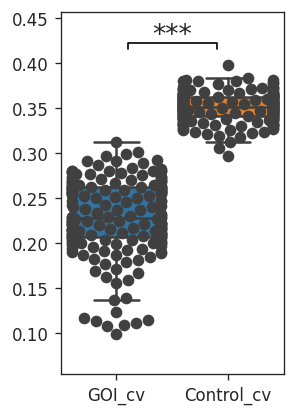

In [ ]:
boxplot_with_pvalue(num, ls)

In [ ]:
wilcoxon(
    out[out.FGES_source == "Random_FGES"].GOI_cv,
    out[out.FGES_source == "Random_FGES"].Control_cv,
)

WilcoxonResult(statistic=0.0, pvalue=6.262919771371905e-33)

In [ ]:
print_95ci_of_mean(out[out.FGES_source == "Random_FGES"].GOI_cv)

Mean: 0.22912027703484927±0.005980911091789986
95% CI: (0.22313936594305928, 0.23510118812663927)


In [ ]:
print_95ci_of_mean(out[out.FGES_source == "Random_FGES"].Control_cv)

Mean: 0.35084711498122256±0.002221628758441505
95% CI: (0.34862548622278106, 0.35306874373966407)


In [ ]:
out[out.FGES_source == "Random_FGES"].GOI_cv.quantile(0.25), out[
    out.FGES_source == "Random_FGES"
].GOI_cv.mean(), out[out.FGES_source == "Random_FGES"].GOI_cv.quantile(0.75)

(0.20697006738182835, 0.22912027703484927, 0.2619868739493144)

In [ ]:
out[out.FGES_source == "Random_FGES"].Control_cv.quantile(0.25), out[
    out.FGES_source == "Random_FGES"
].Control_cv.mean(), out[out.FGES_source == "Random_FGES"].Control_cv.quantile(0.75)

(0.34143707081735997, 0.35084711498122256, 0.3618888694876109)

In [49]:
out.Control_cv.groupby(out.FGES_source).mean().sort_values(ascending=True)

FGES_source
MSigDb_Dif_Expression           0.291165
KEGG                            0.328910
Random_FGES                     0.350847
MSigDb_Other                    0.352439
Human_Phenotype_Ontology        0.353452
MSigDb_Single_Cell              0.374414
xCell                           0.375060
WikiPathways                    0.388882
Reactome                        0.396327
Pathway_Interaction_Database    0.408225
Gene_Ontology                   0.425419
Bindea                          0.480139
BioCarta                        0.483172
Nirmal                          0.514850
Internal                        0.614201
Name: Control_cv, dtype: float64

# Why it's easier to raaise specificity for certain cell types?


In [ ]:
out = read_dataset("fges_stats_table.tsv", index_col=None)

In [51]:
out.FGES_source.unique()

array(['MSigDb_Single_Cell', 'xCell', 'Internal', 'MSigDb_Dif_Expression',
       'Nirmal', 'Gene_Ontology', 'Bindea', 'MSigDb_Other', 'Reactome',
       'WikiPathways', 'KEGG', 'Human_Phenotype_Ontology', 'Random_FGES',
       'BioCarta', 'Pathway_Interaction_Database'], dtype=object)

,GOI_Mean,GOI_p_adj_paired_wilcoxon,Control_Mean,Control_p_adj_paired_wilcoxon,F_score,Accuracy,PR_AUC,ROC_AUC,GOI_cv,Control_cv,BG_FGES,Alt_FGES,FGES_source
TRAVAGLINI_LUNG_B_CELL,8229.018746,7.433997e-03,3284.193987,0.000000,0.997551,0.997548,1.000000,1.000000,0.081495,0.326880,Main4_B_cells,TRAVAGLINI_LUNG_B_CELL,MSigDb_Single_Cell
B_CELLS_NOVERSHTERN_2_XCELL,6082.843030,5.760222e-84,1765.549975,0.000000,0.997377,0.997373,0.999998,0.999996,0.133332,0.340831,Main4_B_cells,B_CELLS_NOVERSHTERN_2_XCELL,xCell
Main4_B_cells,8145.053743,1.000000e+00,-2136.004534,1.000000,0.997376,0.997373,0.999997,0.999993,0.087163,0.530021,Main4_B_cells,Main4_B_cells,Internal
GSE29618_BCELL_VS_MONOCYTE_DAY7_FLU_VACCINE_UP,7283.305226,1.937829e-76,3360.319765,0.000000,0.997202,0.997198,1.000000,1.000000,0.108656,0.317802,Main4_B_cells,GSE29618_BCELL_VS_MONOCYTE_DAY7_FLU_VACCINE_UP,MSigDb_Dif_Expression
CLASS_SWITCHED_MEMORY_B_CELLS_NOVERSHTERN_1_XCELL,5335.457679,5.760222e-84,-2163.600559,0.225194,0.997201,0.997198,0.999929,0.999857,0.182089,0.504252,Main4_B_cells,CLASS_SWITCHED_MEMORY_B_CELLS_NOVERSHTERN_1_XCELL,xCell
...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSE20366_CD103_POS_VS_CD103_KLRG1_DP_TREG_DN,1106.938617,1.302921e-13,1562.735835,0.000000,0.336387,0.398089,0.315780,0.204452,0.246739,0.367577,Main4_Treg,GSE20366_CD103_POS_VS_CD103_KLRG1_DP_TREG_DN,MSigDb_Dif_Expression
GSE18148_CBFB_KO_VS_WT_TREG_DN,605.676019,1.302921e-13,1167.794134,0.000000,0.331810,0.400000,0.307417,0.168281,0.279873,0.376024,Main4_Treg,GSE18148_CBFB_KO_VS_WT_TREG_DN,MSigDb_Dif_Expression
GSE15659_TREG_VS_TCONV_UP,855.745129,1.302921e-13,1162.448032,0.000000,0.325879,0.366242,0.319515,0.220515,0.265822,0.350813,Main4_Treg,GSE15659_TREG_VS_TCONV_UP,MSigDb_Dif_Expression
GSE13306_TREG_VS_TCONV_LAMINA_PROPRIA_UP,2298.257808,1.302921e-13,2635.455824,0.000000,0.325093,0.382803,0.316859,0.211840,0.219139,0.312268,Main4_Treg,GSE13306_TREG_VS_TCONV_LAMINA_PROPRIA_UP,MSigDb_Dif_Expression


In [ ]:
all_stats_by_ct = {}
for sign in out.BG_FGES.unique():
    mask = (out.BG_FGES == sign) & (
        ~out.FGES_source.isin(["Random_FGES", "MSigDb_Dif_Expression"])
    )
    part = pd.concat(
        [
            d[
                [
                    "Control_Mean",
                    "F_score",
                    "Accuracy",
                    "PR_AUC",
                    "ROC_AUC",
                    "GOI_cv",
                    "Control_cv",
                ]
            ].mean()
            for group, d in out[mask].groupby("FGES_source")
        ],
        axis=1,
    ).T.mean()
    part = pd.concat(
        [
            part,
            pd.Series(
                data=out[mask][out.FGES_source != "BostonGene"][
                    ["Control_p_adj_paired_wilcoxon", "GOI_p_adj_paired_wilcoxon"]
                ].max(),
                index=["Control_p_adj_paired_wilcoxon", "GOI_p_adj_paired_wilcoxon"],
            ),
        ]
    )
    all_stats_by_ct[sign] = part
all_stats_by_ct = pd.DataFrame(all_stats_by_ct)

<Axes: >

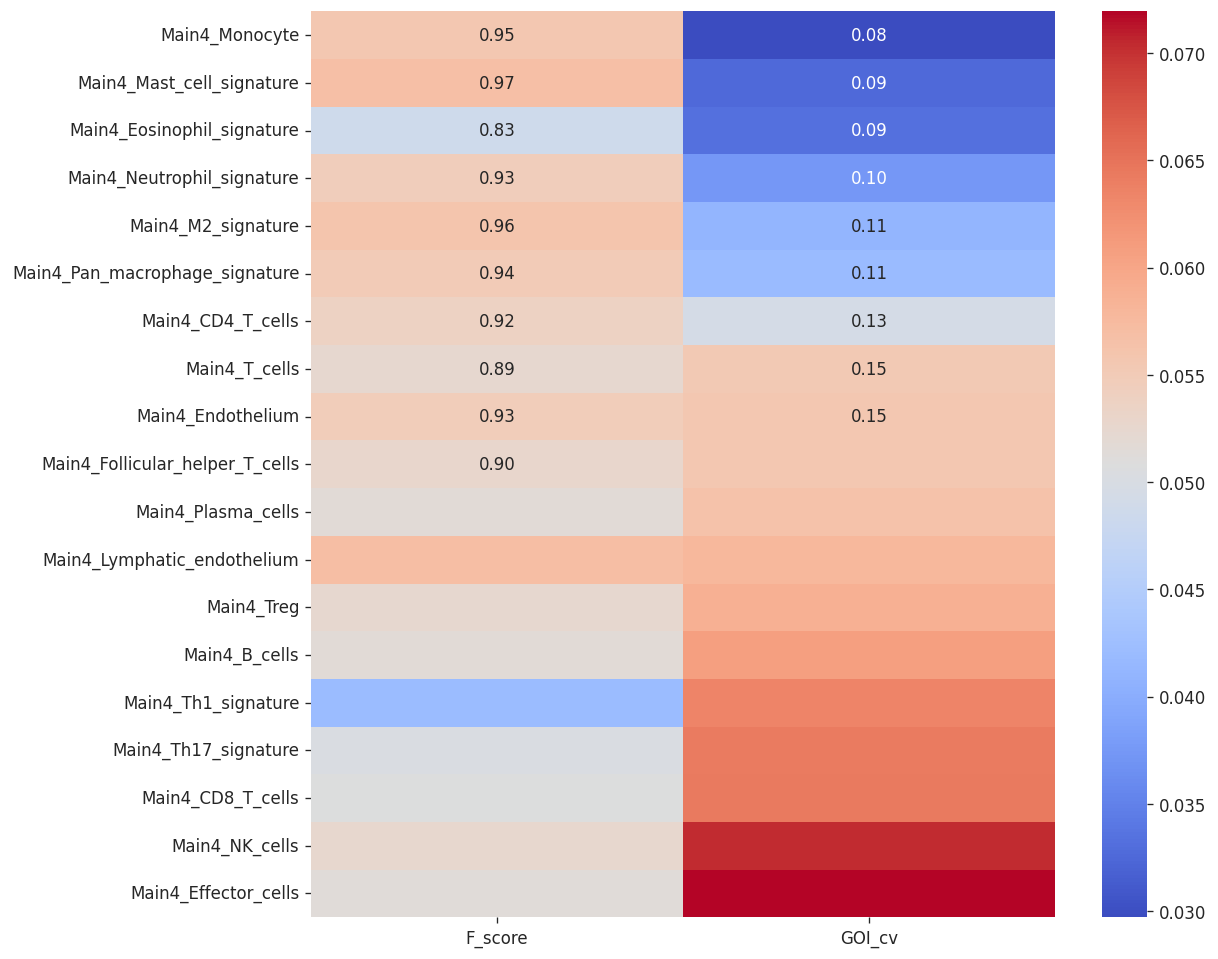

In [ ]:
x = all_stats_by_ct.T.drop(
    columns=["Control_p_adj_paired_wilcoxon", "GOI_p_adj_paired_wilcoxon"]
)[["F_score", "GOI_cv"]].sort_values(by="GOI_cv")

fig, ax = plt.subplots(figsize=(10, 10))

data = x / x.sum()

sns.heatmap(data, annot=x, fmt=".2f", cmap=default_cmap, ax=ax)

In [ ]:
(
    x.F_score.rank(pct=True, ascending=True) * x.GOI_cv.rank(pct=True, ascending=False)
).sort_values()

Main4_Effector_cells               0.013850
Main4_Th1_signature                0.013850
Main4_CD8_T_cells                  0.033241
Main4_Th17_signature               0.033241
Main4_NK_cells                     0.055402
Main4_Eosinophil_signature         0.094183
Main4_B_cells                      0.116343
Main4_Plasma_cells                 0.149584
Main4_Treg                         0.174515
Main4_T_cells                      0.265928
Main4_Follicular_helper_T_cells    0.304709
Main4_Lymphatic_endothelium        0.421053
Main4_Endothelium                  0.426593
Main4_CD4_T_cells                  0.432133
Main4_Neutrophil_signature         0.576177
Main4_Pan_macrophage_signature     0.581717
Main4_M2_signature                 0.706371
Main4_Monocyte                     0.842105
Main4_Mast_cell_signature          0.897507
dtype: float64

<Axes: >

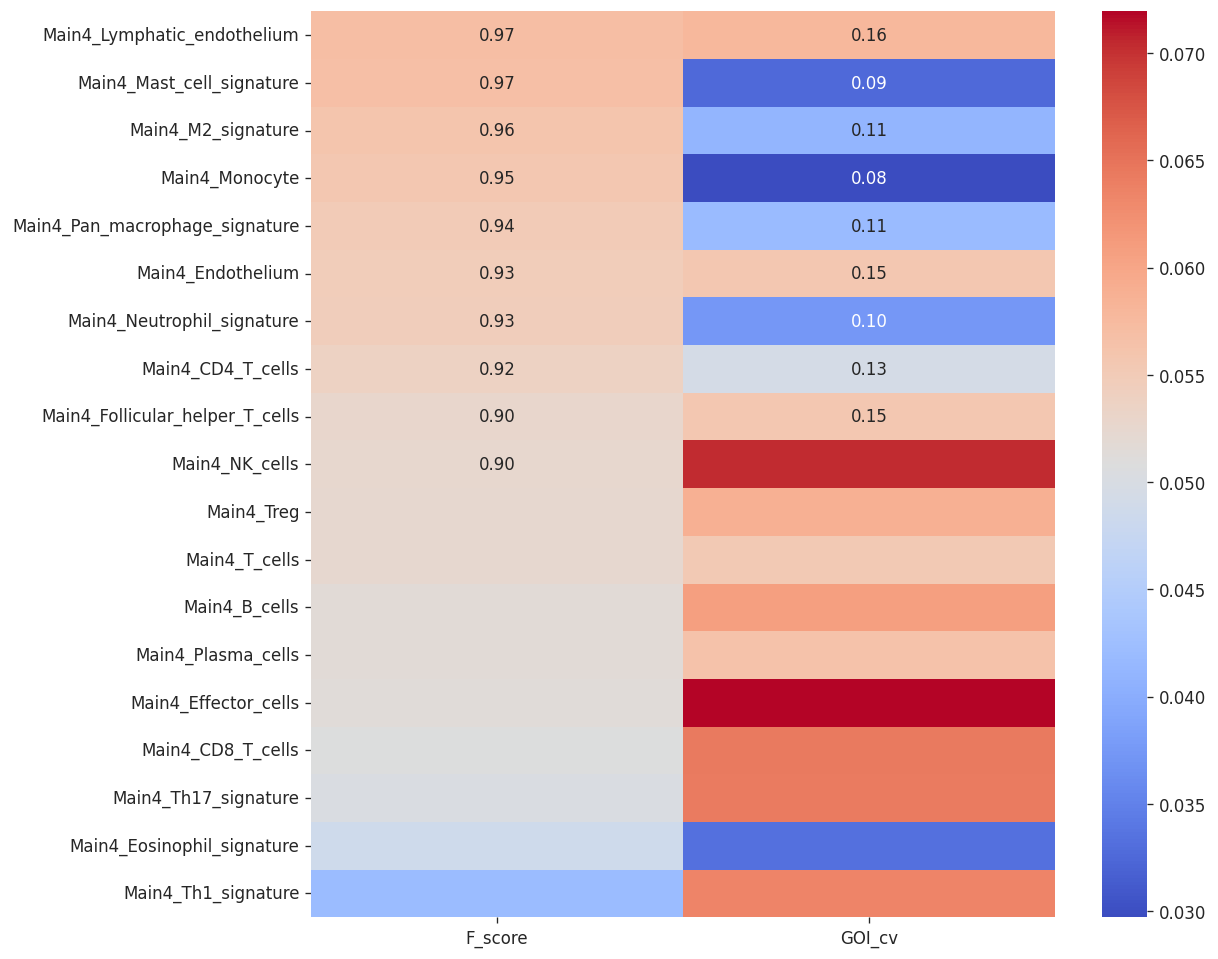

In [ ]:
x = all_stats_by_ct.T.drop(
    columns=["Control_p_adj_paired_wilcoxon", "GOI_p_adj_paired_wilcoxon"]
)[["F_score", "GOI_cv"]].sort_values(by="F_score", ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))

data = x / x.sum()

sns.heatmap(data, annot=x, fmt=".2f", cmap=default_cmap, ax=ax)

In [89]:
out

,GOI_Mean,GOI_p_adj_paired_wilcoxon,Control_Mean,Control_p_adj_paired_wilcoxon,F_score,Accuracy,PR_AUC,ROC_AUC,GOI_cv,Control_cv,BG_FGES,Alt_FGES,FGES_source
TRAVAGLINI_LUNG_B_CELL,8229.018746,7.433997e-03,3284.193987,0.000000,0.997551,0.997548,1.000000,1.000000,0.081495,0.326880,Main4_B_cells,TRAVAGLINI_LUNG_B_CELL,MSigDb_Single_Cell
B_CELLS_NOVERSHTERN_2_XCELL,6082.843030,5.760222e-84,1765.549975,0.000000,0.997377,0.997373,0.999998,0.999996,0.133332,0.340831,Main4_B_cells,B_CELLS_NOVERSHTERN_2_XCELL,xCell
Main4_B_cells,8145.053743,1.000000e+00,-2136.004534,1.000000,0.997376,0.997373,0.999997,0.999993,0.087163,0.530021,Main4_B_cells,Main4_B_cells,Internal
GSE29618_BCELL_VS_MONOCYTE_DAY7_FLU_VACCINE_UP,7283.305226,1.937829e-76,3360.319765,0.000000,0.997202,0.997198,1.000000,1.000000,0.108656,0.317802,Main4_B_cells,GSE29618_BCELL_VS_MONOCYTE_DAY7_FLU_VACCINE_UP,MSigDb_Dif_Expression
CLASS_SWITCHED_MEMORY_B_CELLS_NOVERSHTERN_1_XCELL,5335.457679,5.760222e-84,-2163.600559,0.225194,0.997201,0.997198,0.999929,0.999857,0.182089,0.504252,Main4_B_cells,CLASS_SWITCHED_MEMORY_B_CELLS_NOVERSHTERN_1_XCELL,xCell
...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSE20366_CD103_POS_VS_CD103_KLRG1_DP_TREG_DN,1106.938617,1.302921e-13,1562.735835,0.000000,0.336387,0.398089,0.315780,0.204452,0.246739,0.367577,Main4_Treg,GSE20366_CD103_POS_VS_CD103_KLRG1_DP_TREG_DN,MSigDb_Dif_Expression
GSE18148_CBFB_KO_VS_WT_TREG_DN,605.676019,1.302921e-13,1167.794134,0.000000,0.331810,0.400000,0.307417,0.168281,0.279873,0.376024,Main4_Treg,GSE18148_CBFB_KO_VS_WT_TREG_DN,MSigDb_Dif_Expression
GSE15659_TREG_VS_TCONV_UP,855.745129,1.302921e-13,1162.448032,0.000000,0.325879,0.366242,0.319515,0.220515,0.265822,0.350813,Main4_Treg,GSE15659_TREG_VS_TCONV_UP,MSigDb_Dif_Expression
GSE13306_TREG_VS_TCONV_LAMINA_PROPRIA_UP,2298.257808,1.302921e-13,2635.455824,0.000000,0.325093,0.382803,0.316859,0.211840,0.219139,0.312268,Main4_Treg,GSE13306_TREG_VS_TCONV_LAMINA_PROPRIA_UP,MSigDb_Dif_Expression


GSE11961_GERMINAL_CENTER_BCELL_DAY7_VS_PLASMA_CELL_DAY7_UP                                        0.236365
GSE37532_TREG_VS_TCONV_CD4_TCELL_FROM_VISCERAL_ADIPOSE_TISSUE_DN                                  0.151859
ZAK_PBMC_MRKAD5_HIV_1_GAG_POL_NEF_AGE_20_50YO_CORRELATED_WITH_CD8_T_CELL_RESPONSE_3DY_POSITIVE    0.149615
GSE3982_NEUTROPHIL_VS_NKCELL_DN                                                                   0.180477
WP_NOTCH1_REGULATION_OF_ENDOTHELIAL_CELL_CALCIFICATION                                            0.208729
RANDOM_FGES4_Main4_Eosinophil_signature                                                           0.136638
GSE43863_NAIVE_VS_TFH_CD4_EFF_TCELL_D6_LCMV_DN                                                    0.259994
RANDOM_FGES1_Main4_Lymphatic_endothelium                                                          0.203863
MACROPHAGES_M2_BLUEPRINT_1_XCELL                                                                  0.074560
GOBP_MAST_CELL_MIGRATION             

In [ ]:
out = out[out.FGES_source != "Random_FGES"]

In [ ]:
corrs = {}
for i in range(1000):
    samps = []
    for name, group in out.groupby(out.BG_FGES):
        samps.append(group.sample(1, random_state=i).index[0])
    corrs[i] = calculate_and_plot_correlations(
        out.loc[samps].GOI_cv,
        out.loc[samps].F_score,
        name1="CV",
        name2="F",
        ret=True,
        plot=False,
        verbose=False,
    )

In [140]:
corrs = pd.DataFrame(corrs)

In [125]:
p_value = np.mean(>= np.abs(0))

In [ ]:
print_95ci_of_mean(corrs.loc["Spearman"])

Mean: -0.48±0.011


In [ ]:
out[out.FGES_source == "Random_FGES"].groupby(
    out[out.FGES_source == "Random_FGES"].BG_FGES
).mean().sort_values(by="F_score")

,GOI_Mean,GOI_p_adj_paired_wilcoxon,Control_Mean,Control_p_adj_paired_wilcoxon,F_score,Accuracy,PR_AUC,ROC_AUC,GOI_cv,Control_cv
BG_FGES,,,,,,,,,,
Main4_Mast_cell_signature,1122.590905,5.748833e-10,1236.413050,0.000000e+00,0.438283,0.460786,0.294127,0.375748,0.204968,0.350599
Main4_Th17_signature,1285.248016,3.949706e-06,1333.403171,0.000000e+00,0.482843,0.500411,0.297567,0.439254,0.192835,0.348546
Main4_Endothelium,1288.664542,2.255138e-54,1318.608628,0.000000e+00,0.503606,0.531948,0.609772,0.433505,0.219538,0.350468
Main4_M2_signature,1091.516204,2.552450e-07,1150.178122,0.000000e+00,0.512103,0.514000,0.309067,0.456261,0.214541,0.358255
Main4_B_cells,1262.770101,5.760222e-84,1329.438771,0.000000e+00,0.513046,0.513643,0.622978,0.412462,0.260138,0.348931
Main4_Treg,1280.529095,1.302921e-13,1312.619648,0.000000e+00,0.521681,0.529745,0.419152,0.466872,0.263649,0.353141
Main4_Th1_signature,1246.517446,1.992846e-06,1280.680717,8.474294e-260,0.523053,0.522345,0.309542,0.461644,0.199038,0.345750
Main4_T_cells,1431.800252,1.439112e-28,1329.202366,0.000000e+00,0.536446,0.543259,0.637556,0.525317,0.261633,0.350335
Main4_Effector_cells,1464.453311,3.343231e-108,1352.428498,6.126826e-272,0.538495,0.523843,0.776053,0.531170,0.281433,0.355649


In [ ]:
print_95ci_of_mean(corrs.loc["Spearman"])

Mean: -0.48±0.011


Pearson correlation: -0.4313, p-value: 6.5e-02
Spearman correlation: -0.5544, p-value: 1.4e-02
MSE: 0.5780; MAE: 0.7562
R2: -174.0367
CCC: -0.0029
Number of samples: 19


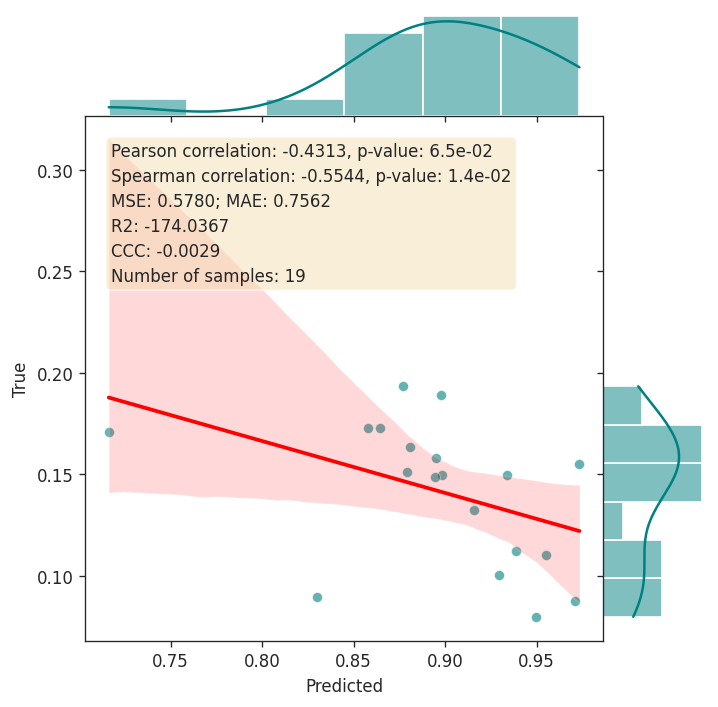

In [ ]:
calculate_and_plot_correlations(x.F_score, x.GOI_cv)

In [ ]:
all_stats_by_ct.T.drop(
    columns=["Control_p_adj_paired_wilcoxon", "GOI_p_adj_paired_wilcoxon"]
)[["F_score", "GOI_cv"]].sort_values(by="F_score", ascending=False).median()

F_score    0.897709
GOI_cv     0.149630
dtype: float64

In [ ]:
kruskal(*[all_stats_by_ct[i] for i in x.index])

KruskalResult(statistic=4.2281541625027, pvalue=0.9996462004480077)

In [ ]:
df = df_fisher_chi2(x[["F_score", "GOI_cv"]], R="F_score", NR="GOI_cv")

In [ ]:
all_stats_by_ct = {typ: {} for typ in out.FGES_source.unique()}
for sign in out.BG_FGES.unique():
    part = out[(out.BG_FGES == sign)]
    for typ in part.FGES_source.unique():
        mask = part.FGES_source == typ
        part_m = part[mask][
            [
                "Control_Mean",
                "F_score",
                "Accuracy",
                "PR_AUC",
                "ROC_AUC",
                "GOI_cv",
                "Control_cv",
            ]
        ].mean()
        part_m = pd.concat(
            [
                part_m,
                pd.Series(
                    data=part[mask][out.FGES_source != "BostonGene"][
                        ["Control_p_adj_paired_wilcoxon", "GOI_p_adj_paired_wilcoxon"]
                    ].max(),
                    index=[
                        "Control_p_adj_paired_wilcoxon",
                        "GOI_p_adj_paired_wilcoxon",
                    ],
                ),
            ]
        )
        all_stats_by_ct[typ][sign] = part_m

In [ ]:
val = (x.F_score > 0.7).value_counts()

In [ ]:
(x.F_score > 0.9).astype("category")

Main4_B_cells                      False
Main4_CD4_T_cells                  False
Main4_CD8_T_cells                  False
Main4_Effector_cells               False
Main4_Endothelium                  False
Main4_Eosinophil_signature         False
Main4_Follicular_helper_T_cells    False
Main4_Lymphatic_endothelium        False
Main4_M2_signature                 False
Main4_Mast_cell_signature          False
Main4_Monocyte                     False
Main4_NK_cells                     False
Main4_Neutrophil_signature         False
Main4_Pan_macrophage_signature     False
Main4_Plasma_cells                 False
Main4_T_cells                      False
Main4_Th17_signature               False
Main4_Th1_signature                False
Main4_Treg                         False
Name: F_score, dtype: category
Categories (1, object): [False]

In [ ]:
fals_pers = {}
thr = 0.07
for typ in [
    "Internal",
    "Nirmal",
    "MSigDb_Single_Cell",
    "xCell",
    "Human_Phenotype_Ontology",
    "Bindea",
    "MSigDb_Other",
    "WikiPathways",
    "Gene_Ontology",
    "MSigDb_Dif_Expression",
    "Random_FGES",
]:
    if len([typ]) > 0:
        df = pd.DataFrame(all_stats_by_ct[typ])
        x = df.T.drop(
            columns=["Control_p_adj_paired_wilcoxon", "GOI_p_adj_paired_wilcoxon"]
        )[["F_score", "GOI_cv"]]
        print(typ)
        val = (x.GOI_cv < thr).value_counts()
        if True not in val.index:
            val = pd.concat([pd.Series(index=[True], data=[0]), val])
        fals_pers[typ] = 100 - (val.loc[True] / val.sum()) * 100
        print(
            f"{val.loc[True]} out of {val.sum()} FGES are above {thr}, {(val.loc[True]/val.sum())*100}%"
        )
        print(
            f"{val.sum()-val.loc[True]} out of {val.sum()} FGES are above {thr}, {100-(val.loc[True]/val.sum())*100}%"
        )
        print()
    else:
        print(typ, "missing")
fals_pers = pd.Series(fals_pers)

Internal
11 out of 19 FGES are above 0.07, 57.89473684210527%
8 out of 19 FGES are above 0.07, 42.10526315789473%

Nirmal
3 out of 7 FGES are above 0.07, 42.857142857142854%
4 out of 7 FGES are above 0.07, 57.142857142857146%

MSigDb_Single_Cell
2 out of 15 FGES are above 0.07, 13.333333333333334%
13 out of 15 FGES are above 0.07, 86.66666666666667%

xCell
3 out of 16 FGES are above 0.07, 18.75%
13 out of 16 FGES are above 0.07, 81.25%

Human_Phenotype_Ontology
0 out of 11 FGES are above 0.07, 0.0%
11 out of 11 FGES are above 0.07, 100.0%

Bindea
2 out of 9 FGES are above 0.07, 22.22222222222222%
7 out of 9 FGES are above 0.07, 77.77777777777777%

MSigDb_Other
1 out of 10 FGES are above 0.07, 10.0%
9 out of 10 FGES are above 0.07, 90.0%

WikiPathways
0 out of 6 FGES are above 0.07, 0.0%
6 out of 6 FGES are above 0.07, 100.0%

Gene_Ontology
0 out of 18 FGES are above 0.07, 0.0%
18 out of 18 FGES are above 0.07, 100.0%

MSigDb_Dif_Expression
0 out of 18 FGES are above 0.07, 0.0%
18 out o

In [ ]:
100 - fals_pers.mean()

12.44341915394547

In [ ]:
fals_pers = {}
thr = 0.95
for typ in [
    "Internal",
    "Nirmal",
    "MSigDb_Single_Cell",
    "xCell",
    "Human_Phenotype_Ontology",
    "Bindea",
    "MSigDb_Other",
    "WikiPathways",
    "Gene_Ontology",
    "MSigDb_Dif_Expression",
    "Random_FGES",
]:
    if len([typ]) > 0:
        df = pd.DataFrame(all_stats_by_ct[typ])
        x = df.T.drop(
            columns=["Control_p_adj_paired_wilcoxon", "GOI_p_adj_paired_wilcoxon"]
        )[["F_score", "GOI_cv"]]
        print(typ)
        val = (x.F_score > thr).value_counts()
        if True not in val.index:
            val = pd.concat([pd.Series(index=[True], data=[0]), val])
        fals_pers[typ] = 100 - (val.loc[True] / val.sum()) * 100
        print(
            f"{val.loc[True]} out of {val.sum()} FGES are above {thr}, {(val.loc[True]/val.sum())*100}%"
        )
        print(
            f"{val.sum()-val.loc[True]} out of {val.sum()} FGES are above {thr}, {100-(val.loc[True]/val.sum())*100}%"
        )
        print()
    else:
        print(typ, "missing")
fals_pers = pd.Series(fals_pers)

Internal
16 out of 19 FGES are above 0.95, 84.21052631578947%
3 out of 19 FGES are above 0.95, 15.789473684210535%

Nirmal
4 out of 7 FGES are above 0.95, 57.14285714285714%
3 out of 7 FGES are above 0.95, 42.85714285714286%

MSigDb_Single_Cell
8 out of 15 FGES are above 0.95, 53.333333333333336%
7 out of 15 FGES are above 0.95, 46.666666666666664%

xCell
8 out of 16 FGES are above 0.95, 50.0%
8 out of 16 FGES are above 0.95, 50.0%

Human_Phenotype_Ontology
2 out of 11 FGES are above 0.95, 18.181818181818183%
9 out of 11 FGES are above 0.95, 81.81818181818181%

Bindea
5 out of 9 FGES are above 0.95, 55.55555555555556%
4 out of 9 FGES are above 0.95, 44.44444444444444%

MSigDb_Other
3 out of 10 FGES are above 0.95, 30.0%
7 out of 10 FGES are above 0.95, 70.0%

WikiPathways
0 out of 6 FGES are above 0.95, 0.0%
6 out of 6 FGES are above 0.95, 100.0%

Gene_Ontology
2 out of 18 FGES are above 0.95, 11.11111111111111%
16 out of 18 FGES are above 0.95, 88.88888888888889%

MSigDb_Dif_Expressio

In [ ]:
100 - fals_pers.mean()

33.190068836001856

In [ ]:
pd.concat(all_stats_by_ct["Internal"], axis=1).T.mean()

Control_Mean                    -1720.993227
F_score                             0.976560
Accuracy                            0.976564
PR_AUC                              0.980516
ROC_AUC                             0.990478
GOI_cv                              0.069185
Control_cv                          0.614201
Control_p_adj_paired_wilcoxon       1.000000
GOI_p_adj_paired_wilcoxon           1.000000
dtype: float64

In [ ]:
for typ in [
    "Internal",
    "Nirmal",
    "MSigDb_Single_Cell",
    "xCell",
    "Human_Phenotype_Ontology",
    "Bindea",
    "MSigDb_Other",
    "WikiPathways",
    "Gene_Ontology",
    "MSigDb_Dif_Expression",
    "Random_FGES",
]:
    print(typ)
    print("F score")
    print_95ci_of_mean(pd.concat(all_stats_by_ct[typ], axis=1).loc["F_score"])
    print("GOI_cv")
    print_95ci_of_mean(pd.concat(all_stats_by_ct[typ], axis=1).loc["GOI_cv"])
    print()

Internal
F score
Mean: 0.98±0.01
GOI_cv
Mean: 0.07±0.024

Nirmal
F score
Mean: 0.97±0.02
GOI_cv
Mean: 0.11±0.071

MSigDb_Single_Cell
F score
Mean: 0.92±0.034
GOI_cv
Mean: 0.12±0.02

xCell
F score
Mean: 0.93±0.042
GOI_cv
Mean: 0.13±0.023

Human_Phenotype_Ontology
F score
Mean: 0.81±0.087
GOI_cv
Mean: 0.15±0.034

Bindea
F score
Mean: 0.92±0.07
GOI_cv
Mean: 0.15±0.061

MSigDb_Other
F score
Mean: 0.84±0.07
GOI_cv
Mean: 0.16±0.039

WikiPathways
F score
Mean: 0.88±0.034
GOI_cv
Mean: 0.17±0.034

Gene_Ontology
F score
Mean: 0.83±0.056
GOI_cv
Mean: 0.19±0.022

MSigDb_Dif_Expression
F score
Mean: 0.67±0.064
GOI_cv
Mean: 0.17±0.018

Random_FGES
F score
Mean: 0.56±0.029
GOI_cv
Mean: 0.23±0.019



In [ ]:
x = pd.concat(all_stats_by_ct["Internal"], axis=1).loc[["F_score", "GOI_cv"]].T
x["Score"] = scale_series(x.F_score) / scale_series(x.GOI_cv)
x.sort_values(by="Score")

,F_score,GOI_cv,Score
Main4_Th17_signature,0.918326,0.204946,0.000000
Main4_Th1_signature,0.939904,0.082531,0.690058
Main4_Effector_cells,0.948254,0.109202,0.718031
Main4_Lymphatic_endothelium,0.989476,0.180436,1.023988
Main4_Treg,0.987889,0.114865,1.584930
Main4_Follicular_helper_T_cells,0.975170,0.080654,1.861445
Main4_T_cells,0.963143,0.055913,2.146299
Main4_CD8_T_cells,0.981645,0.076765,2.181905
Main4_B_cells,0.997376,0.087163,2.389804
Main4_NK_cells,0.980976,0.063587,2.623956


In [71]:
x.F_score.sort_values()

Main4_Th17_signature               0.918326
Main4_Th1_signature                0.939904
Main4_Effector_cells               0.948254
Main4_T_cells                      0.963143
Main4_M2_signature                 0.963484
Main4_Plasma_cells                 0.973001
Main4_Follicular_helper_T_cells    0.975170
Main4_Eosinophil_signature         0.975201
Main4_NK_cells                     0.980976
Main4_CD8_T_cells                  0.981645
Main4_Mast_cell_signature          0.986363
Main4_Treg                         0.987889
Main4_Lymphatic_endothelium        0.989476
Main4_CD4_T_cells                  0.990074
Main4_Pan_macrophage_signature     0.994939
Main4_Neutrophil_signature         0.995473
Main4_Monocyte                     0.996747
Main4_Endothelium                  0.997192
Main4_B_cells                      0.997376
Name: F_score, dtype: float64

In [69]:
x.GOI_cv.sort_values()

Main4_Mast_cell_signature          0.002415
Main4_Neutrophil_signature         0.007429
Main4_Eosinophil_signature         0.017279
Main4_Pan_macrophage_signature     0.025606
Main4_Plasma_cells                 0.028385
Main4_Monocyte                     0.032796
Main4_M2_signature                 0.040731
Main4_CD4_T_cells                  0.046883
Main4_T_cells                      0.055913
Main4_Endothelium                  0.056925
Main4_NK_cells                     0.063587
Main4_CD8_T_cells                  0.076765
Main4_Follicular_helper_T_cells    0.080654
Main4_Th1_signature                0.082531
Main4_B_cells                      0.087163
Main4_Effector_cells               0.109202
Main4_Treg                         0.114865
Main4_Lymphatic_endothelium        0.180436
Main4_Th17_signature               0.204946
Name: GOI_cv, dtype: float64

In [ ]:
other_works = []
msigdb = []
for name, group in out.groupby(out.FGES_source):
    if name in ["Bindea", "Nirmal", "xCell"] and name != "Internal":
        other_works.append(group.groupby(out.BG_FGES).count()["GOI_cv"])
    elif name not in ["Bindea", "Nirmal", "xCell"] and name != "Internal":
        msigdb.append(group.groupby(out.BG_FGES).count()["GOI_cv"])

In [ ]:
other_works = pd.concat(other_works, axis=1)
msigdb = pd.concat(msigdb, axis=1)

In [158]:
msigdb

,GOI_cv,GOI_cv,GOI_cv,GOI_cv,GOI_cv,GOI_cv,GOI_cv,GOI_cv,GOI_cv,GOI_cv
Main4_Effector_cells,1.0,4.0,2.0,1.0,80.0,2.0,14.0,NaN,NaN,1.0
Main4_Eosinophil_signature,1.0,4.0,1.0,NaN,15.0,2.0,1.0,NaN,NaN,NaN
Main4_Monocyte,1.0,6.0,1.0,NaN,123.0,NaN,11.0,NaN,NaN,NaN
Main4_Neutrophil_signature,1.0,6.0,2.0,NaN,72.0,1.0,4.0,1.0,1.0,NaN
Main4_B_cells,NaN,7.0,2.0,1.0,314.0,5.0,13.0,NaN,1.0,3.0
Main4_CD4_T_cells,NaN,2.0,NaN,NaN,401.0,NaN,2.0,NaN,NaN,NaN
Main4_CD8_T_cells,NaN,2.0,NaN,NaN,243.0,2.0,5.0,NaN,NaN,NaN
Main4_Endothelium,NaN,9.0,6.0,NaN,14.0,3.0,43.0,NaN,NaN,3.0
Main4_Follicular_helper_T_cells,NaN,1.0,NaN,NaN,38.0,NaN,NaN,NaN,NaN,NaN
Main4_Lymphatic_endothelium,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN


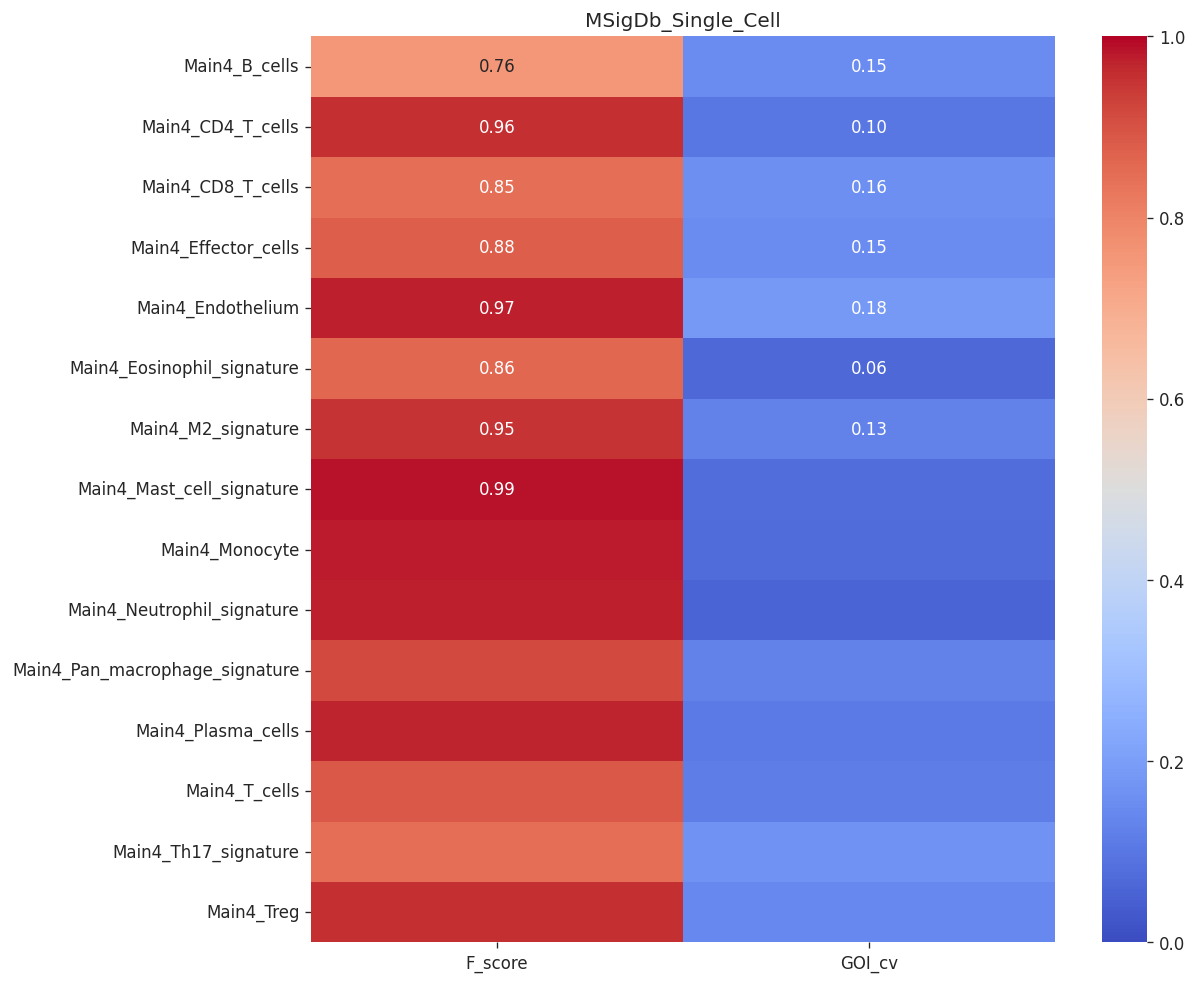

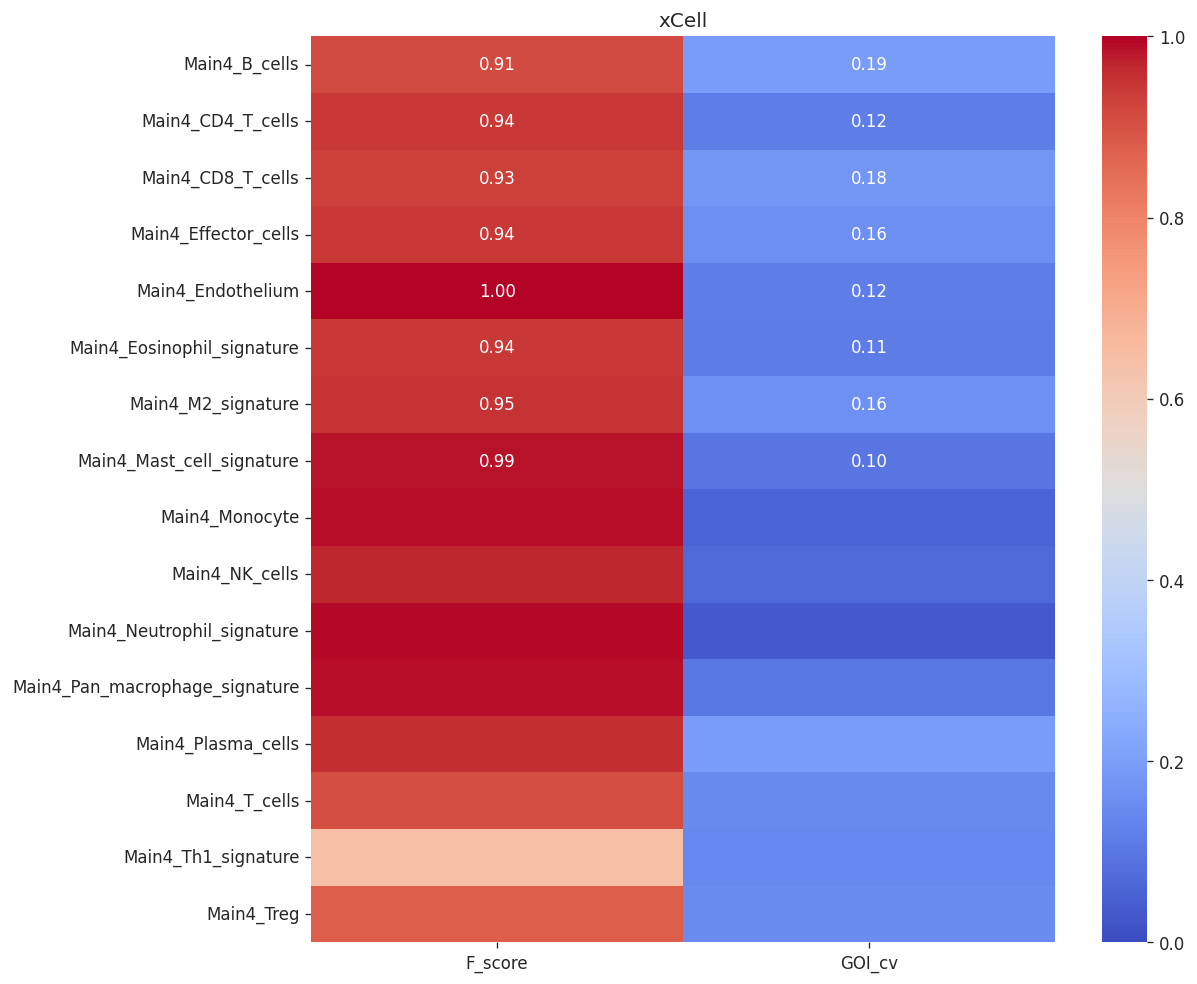

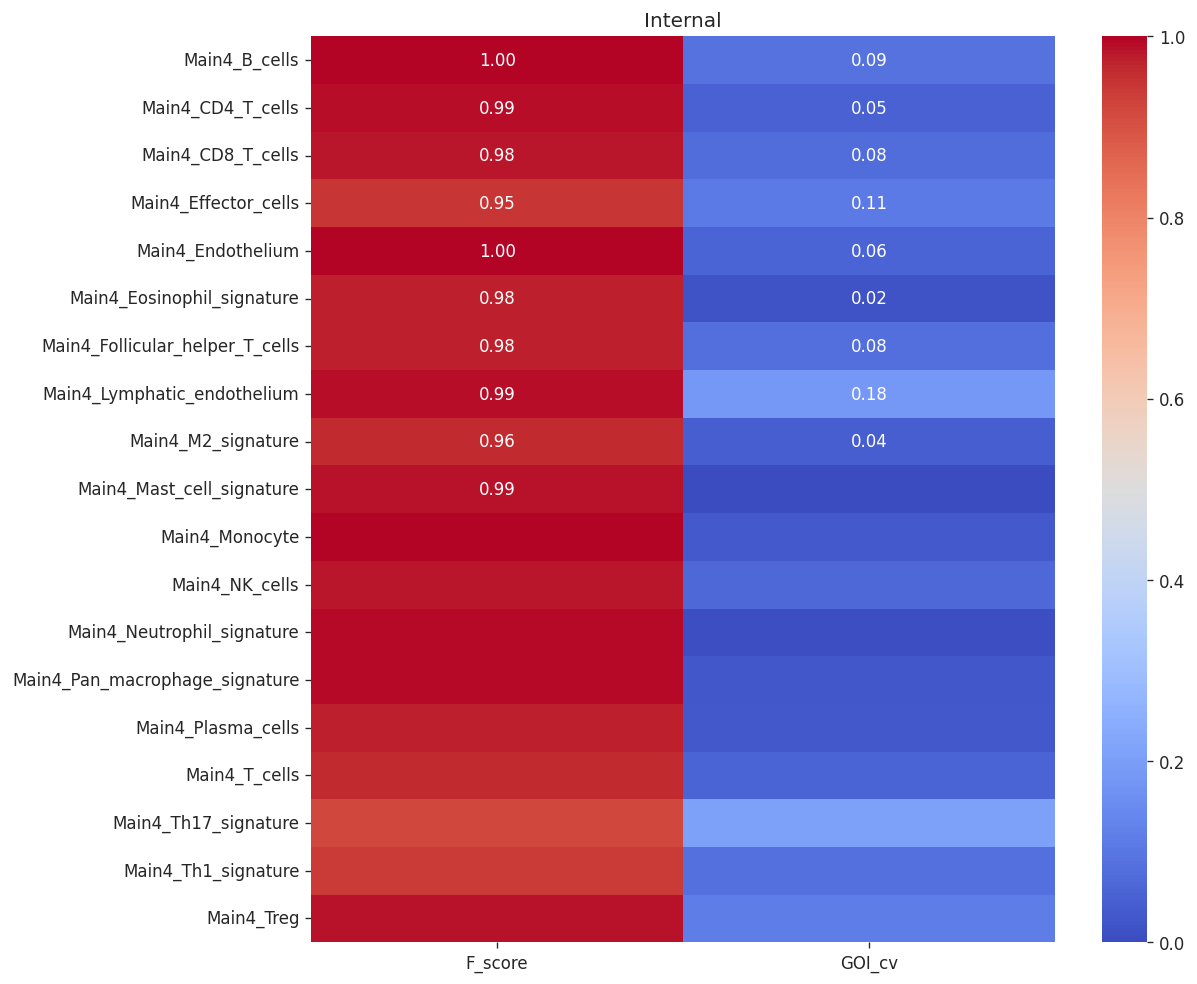

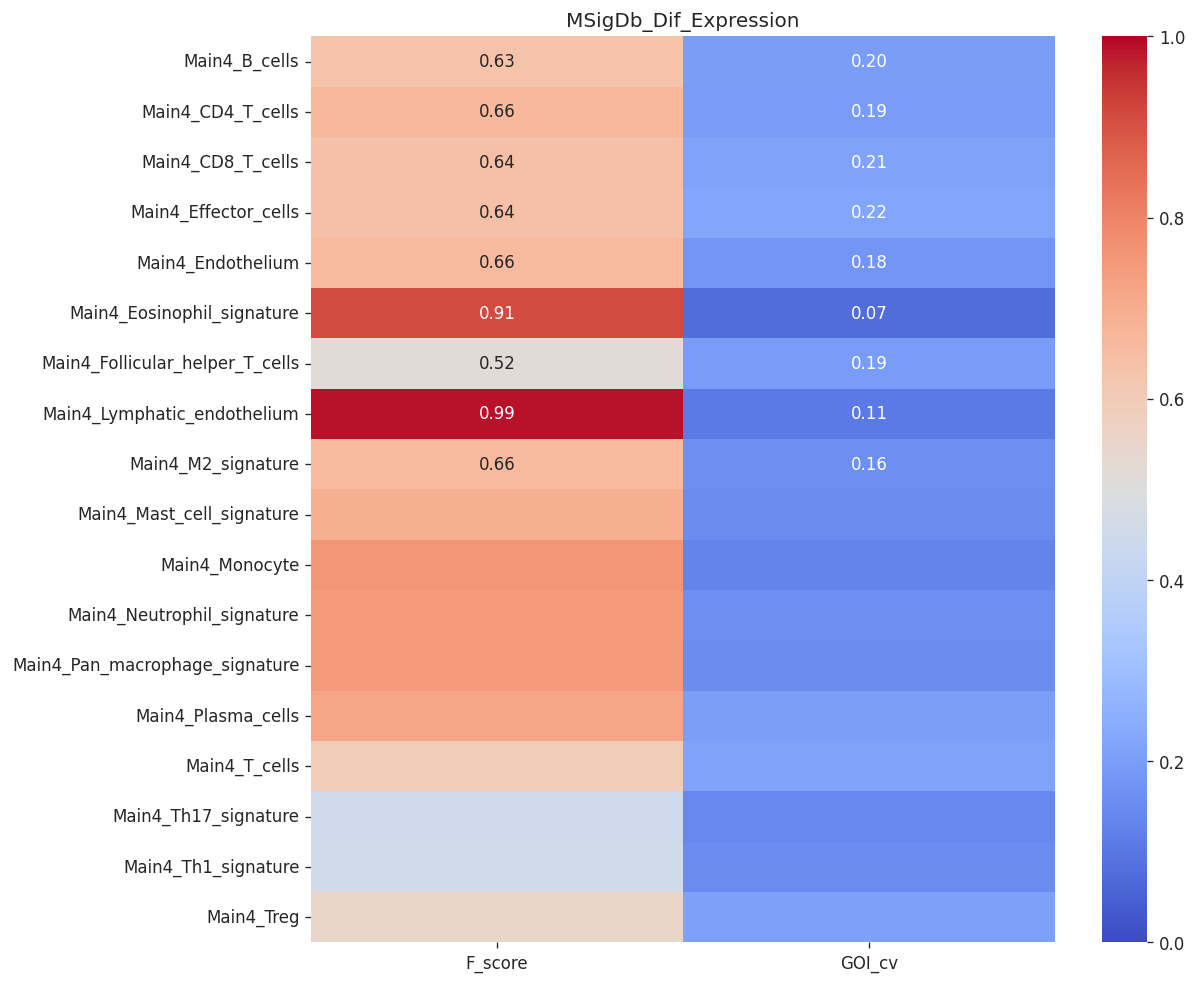

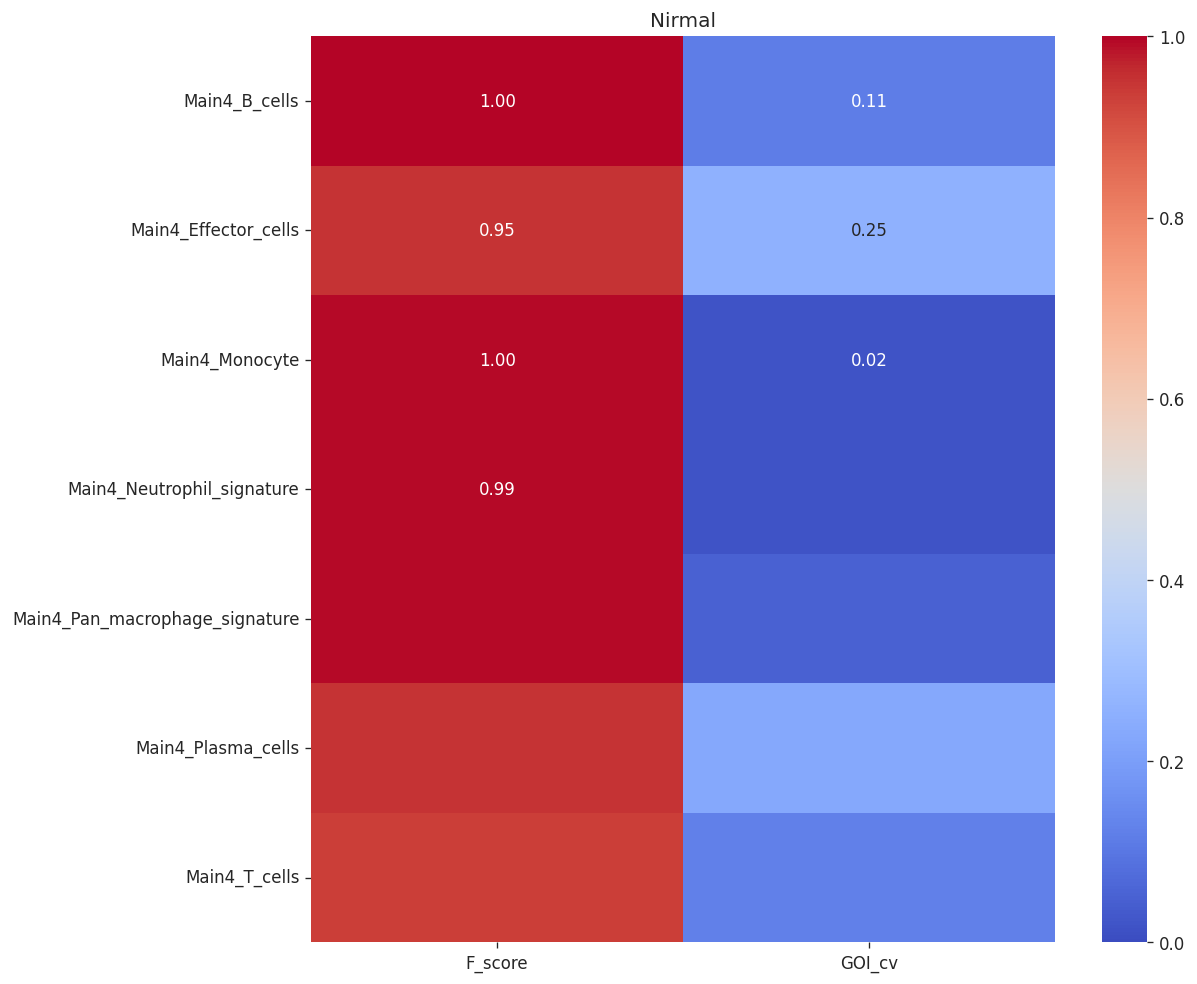

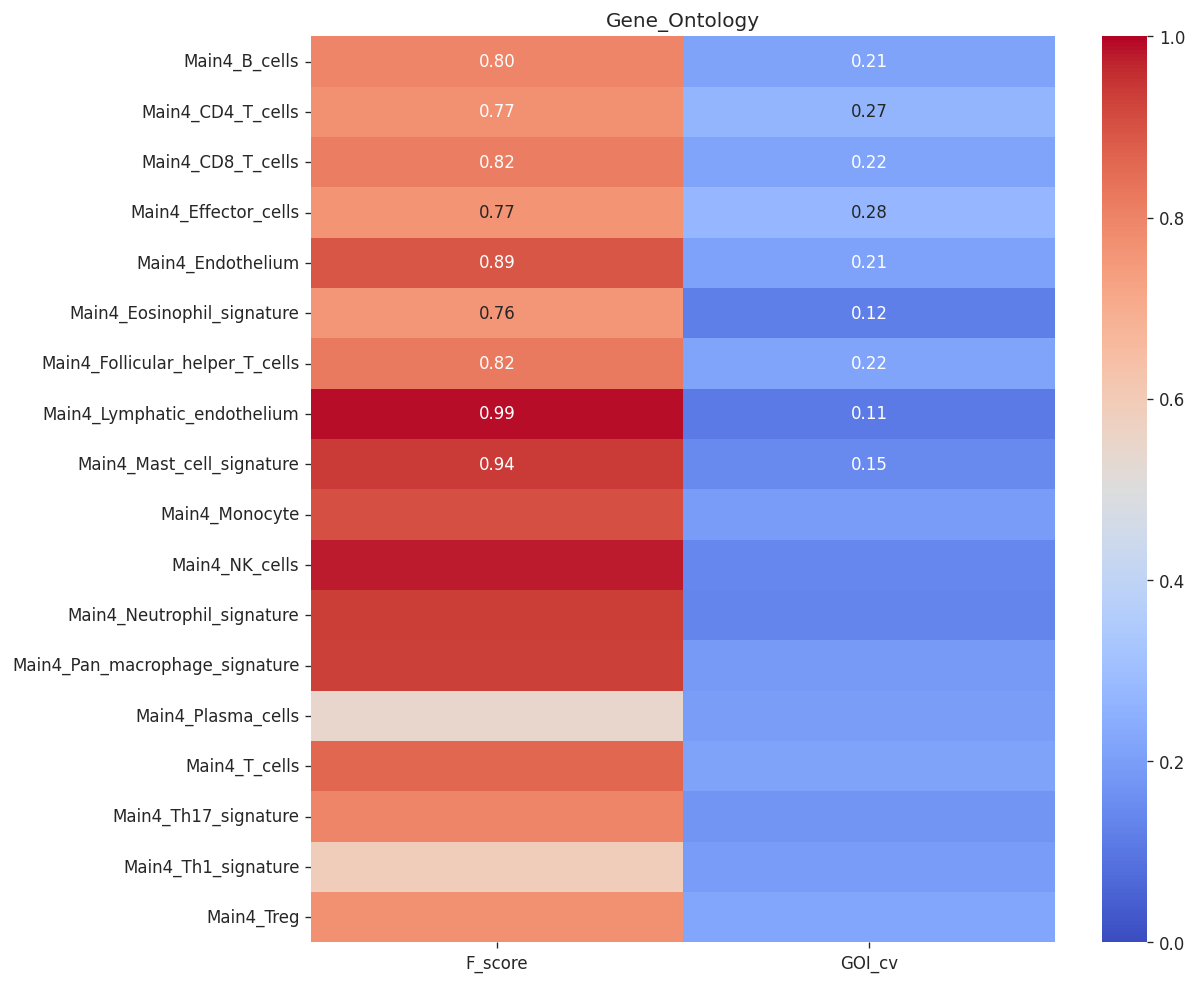

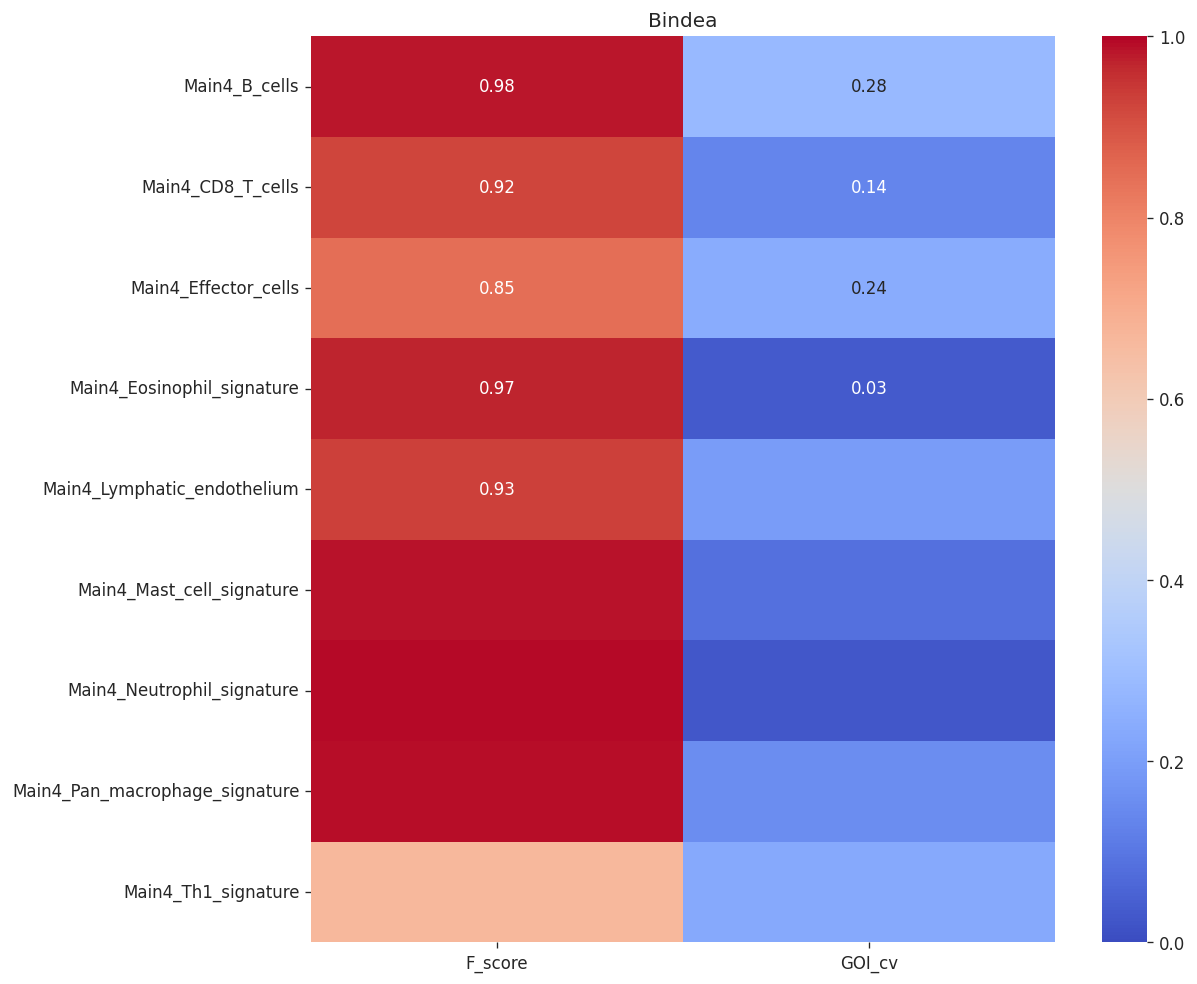

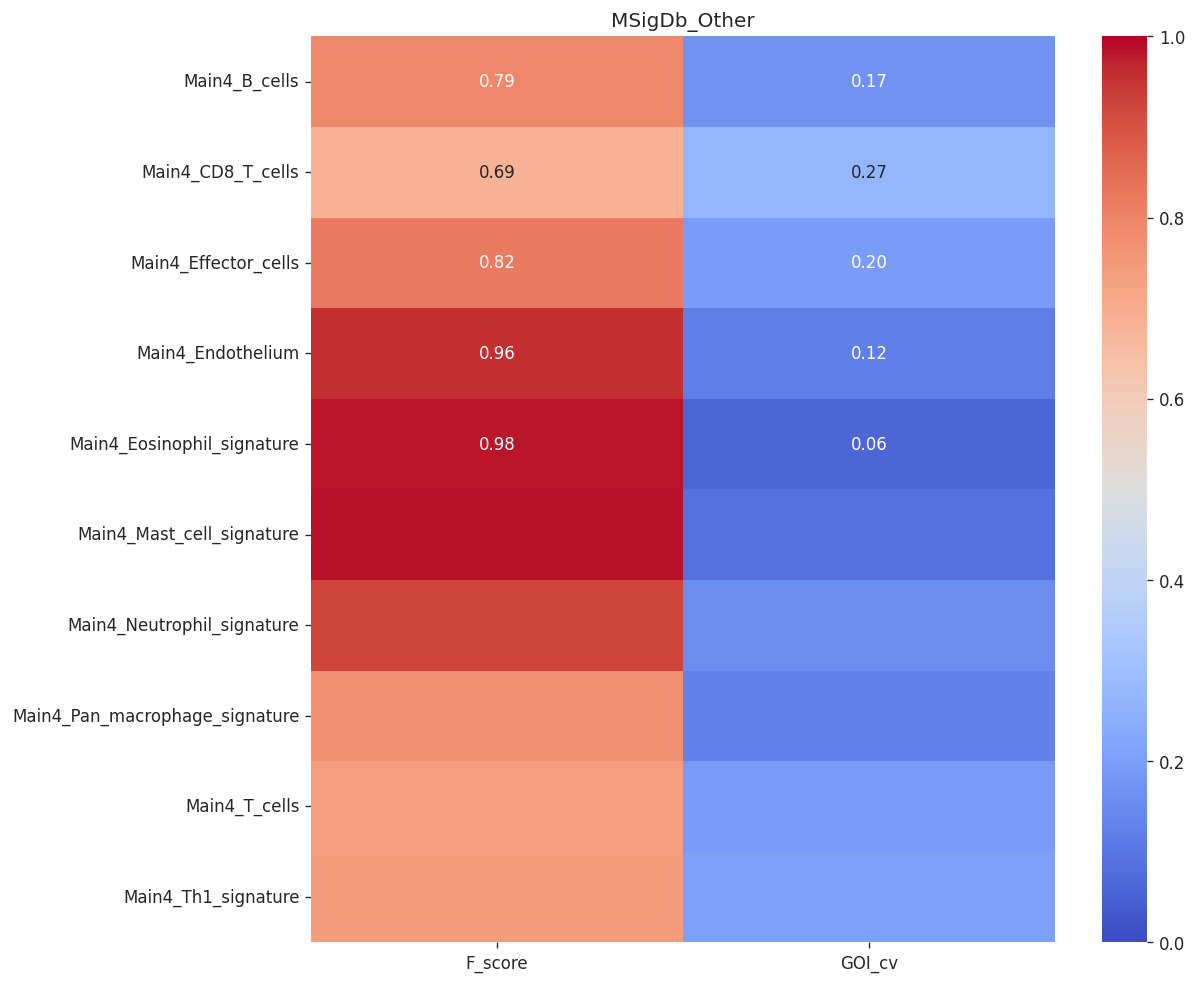

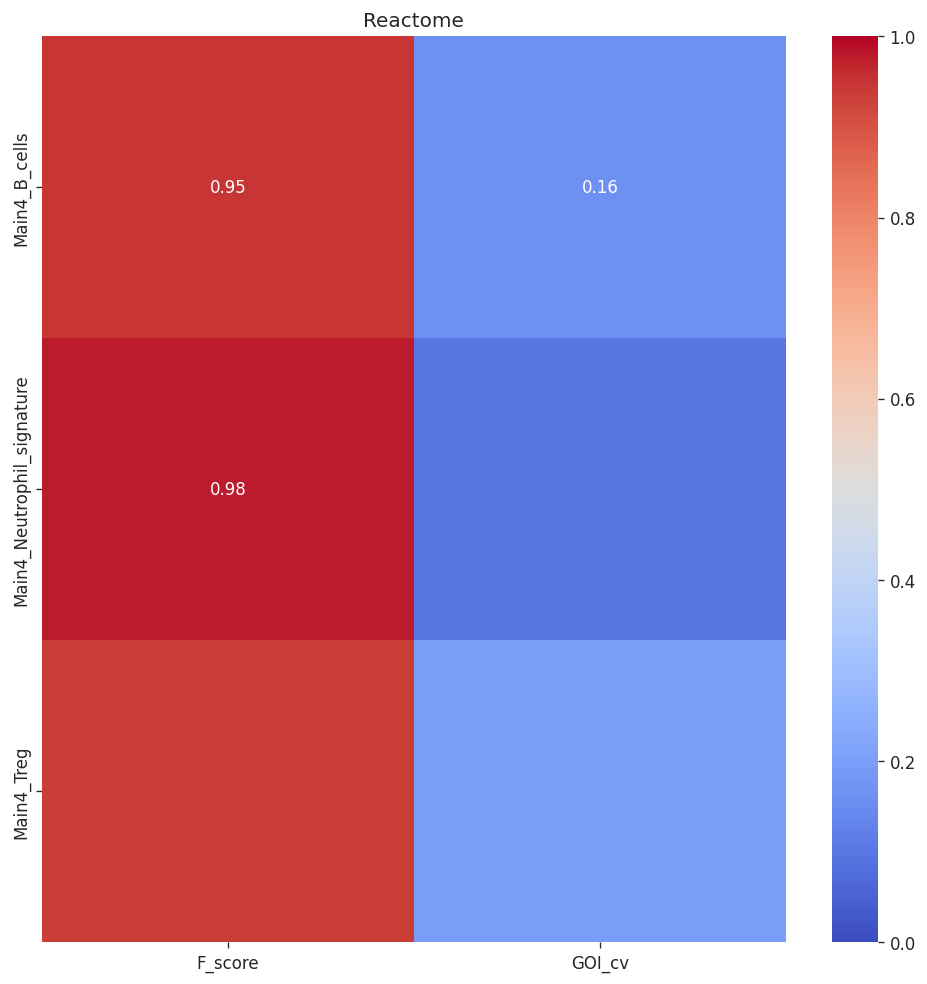

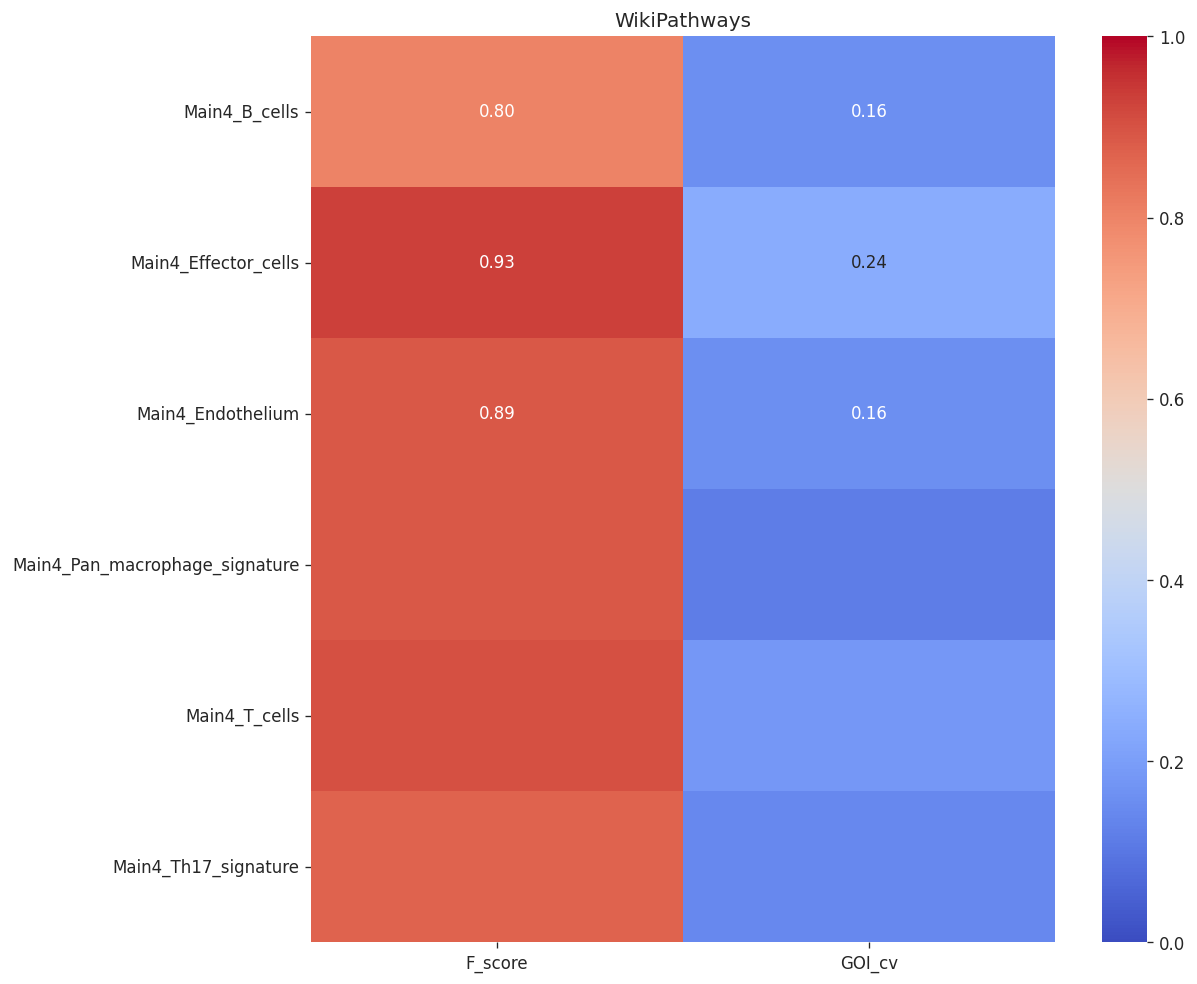

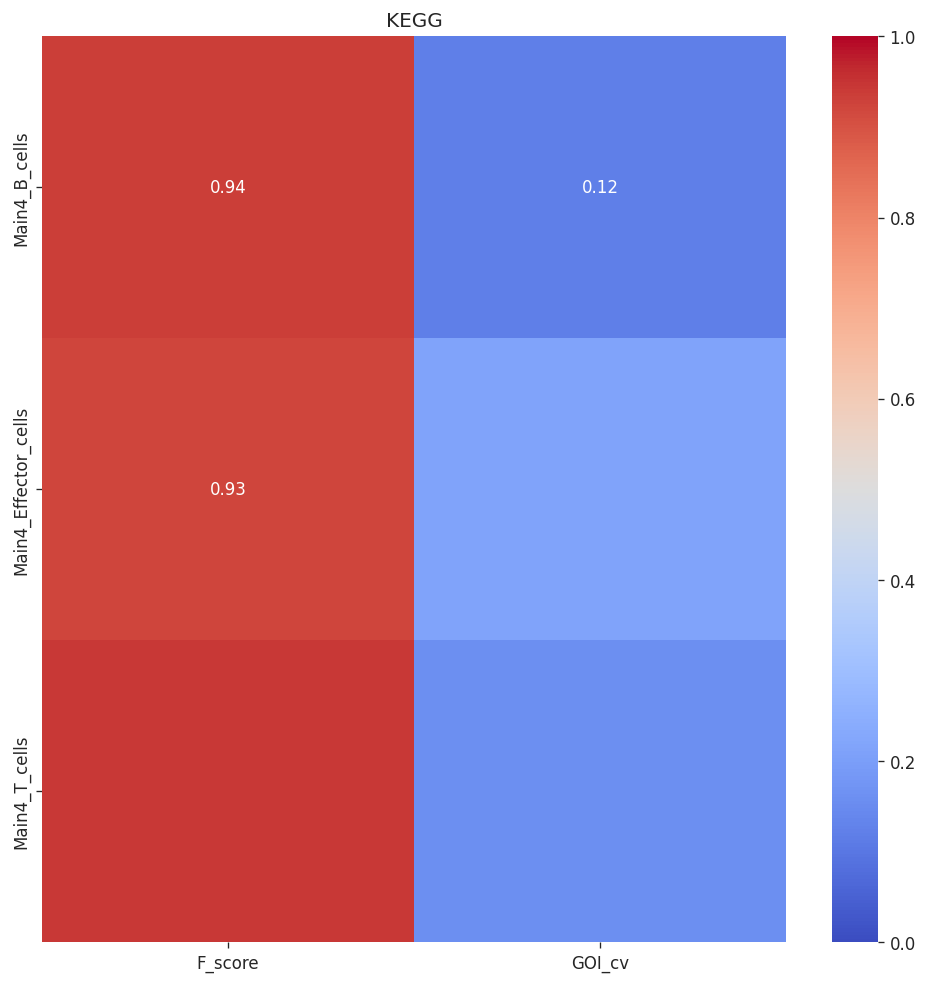

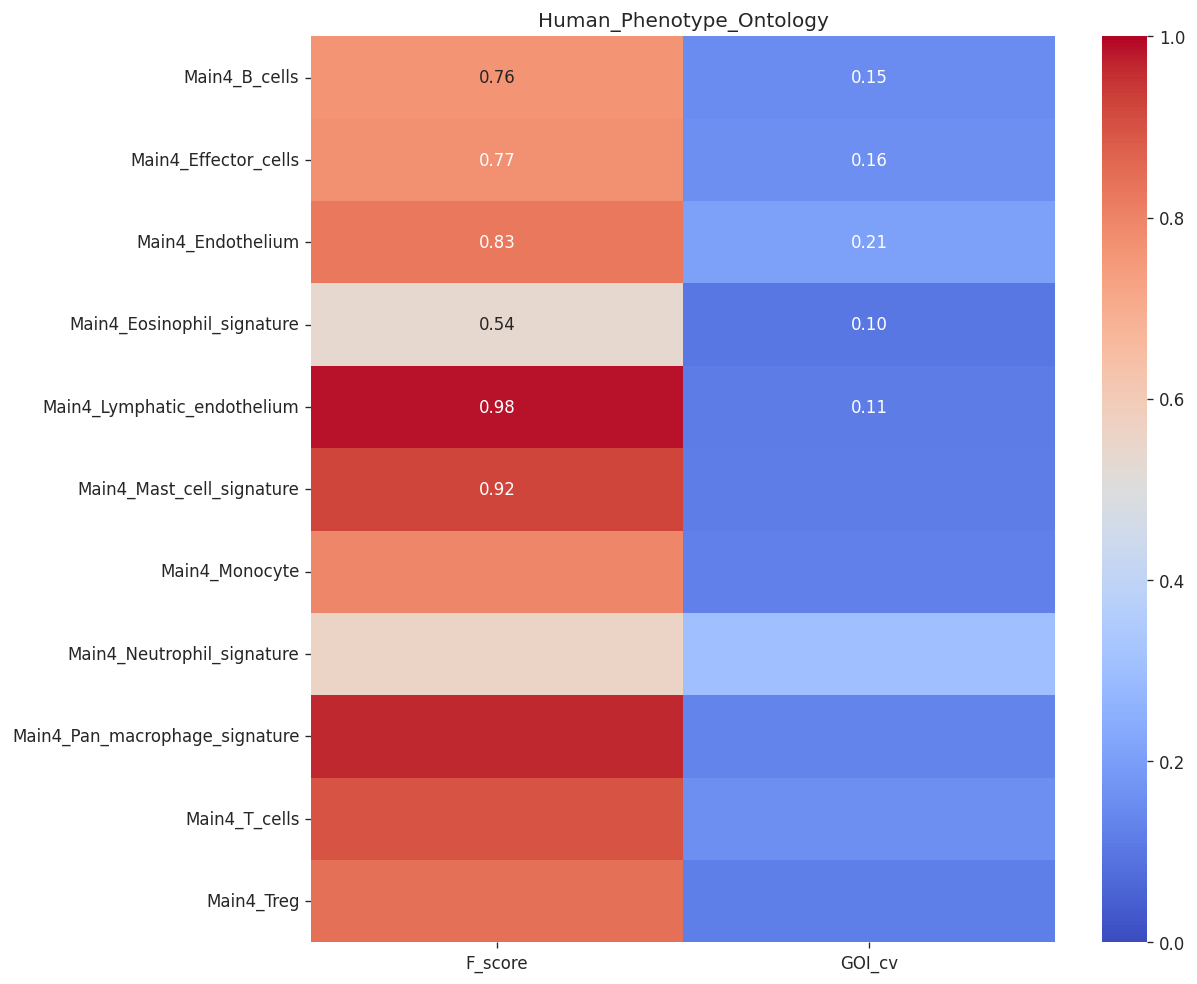

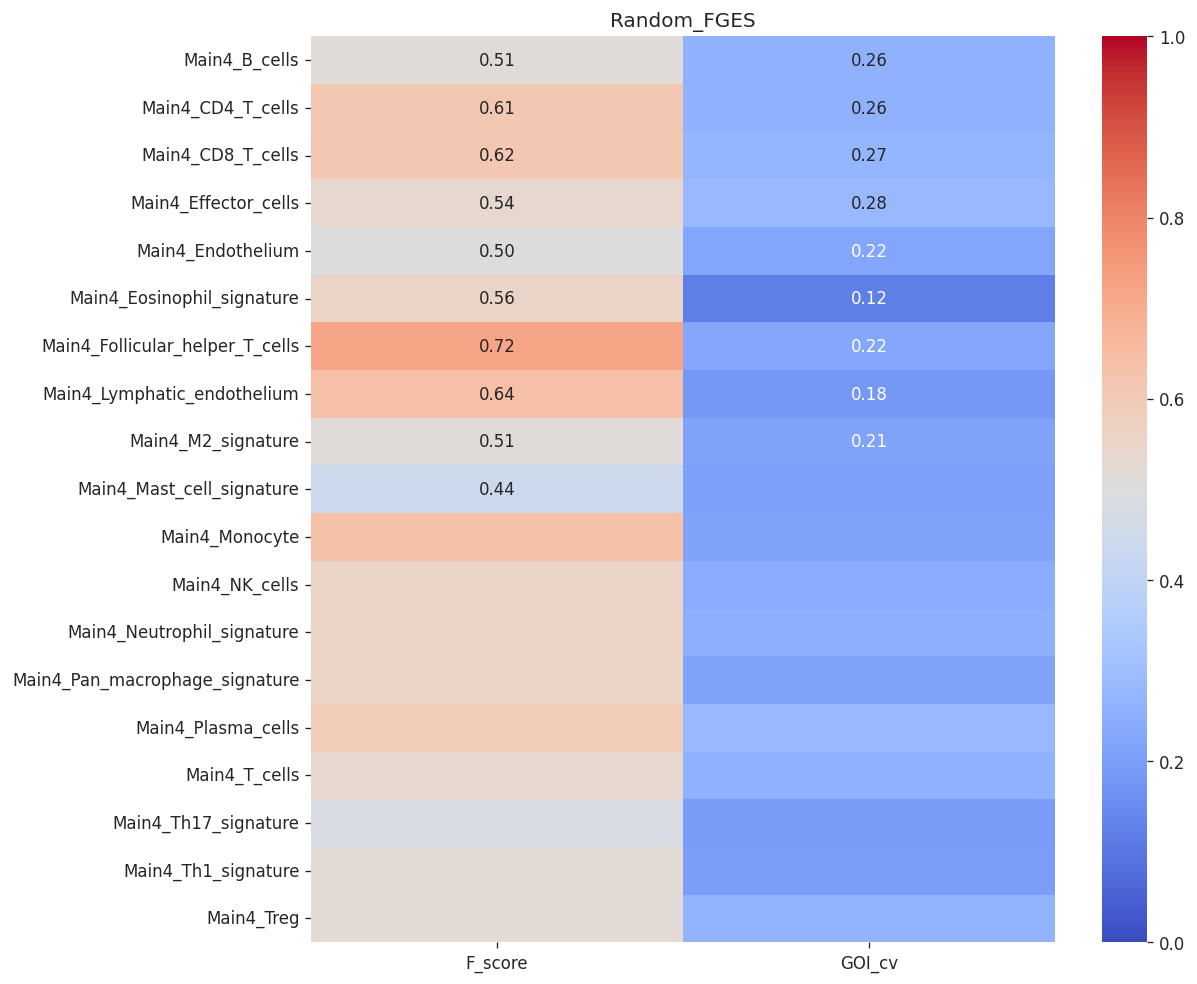

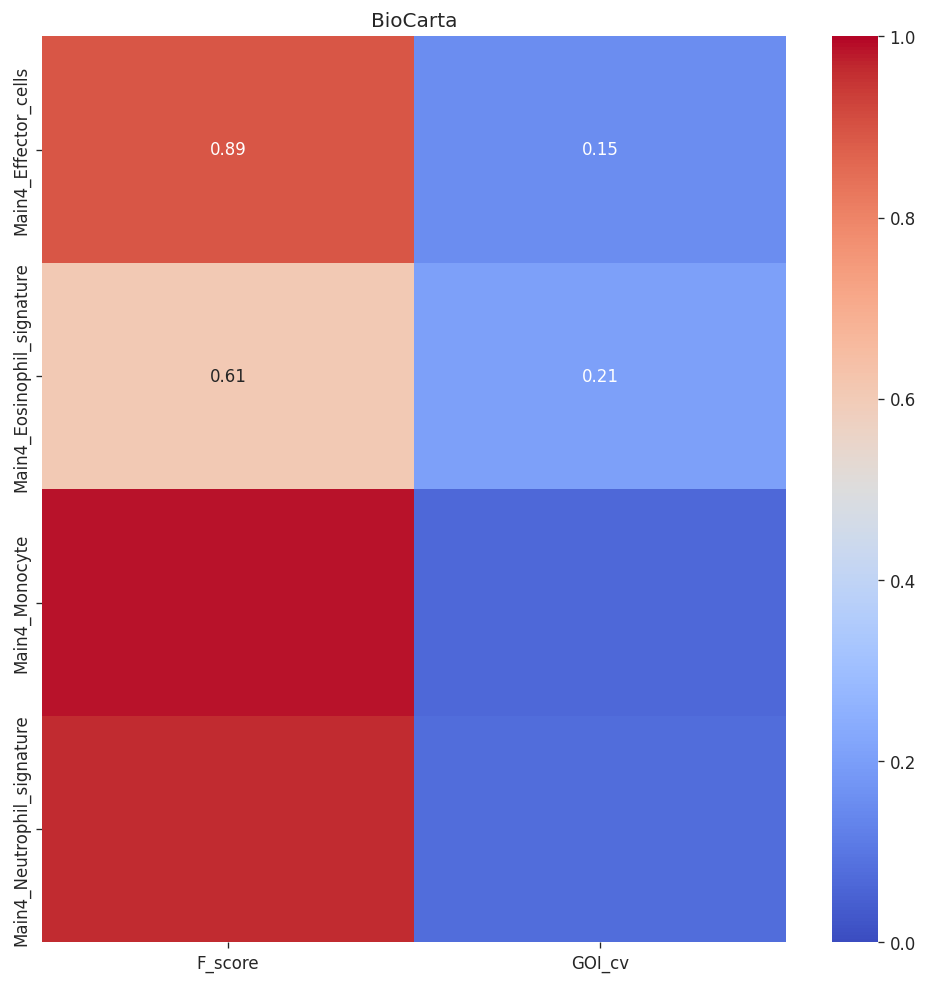

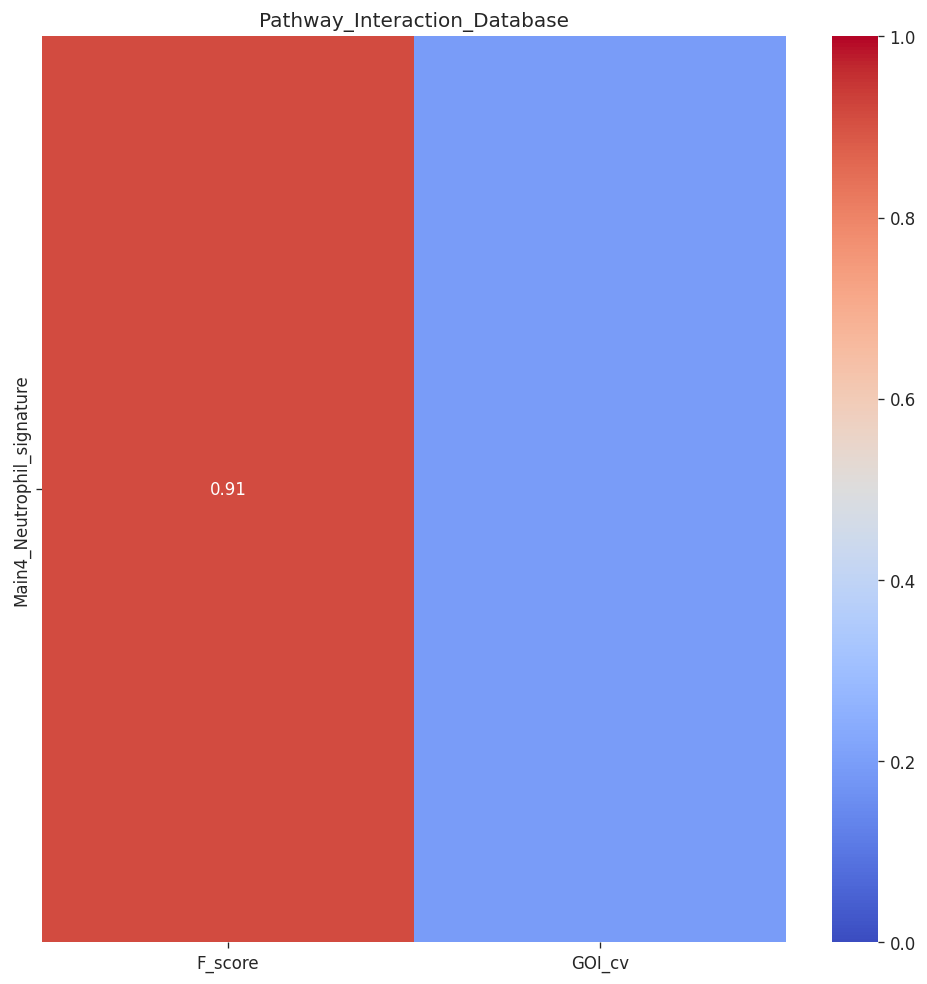

In [ ]:
for typ in all_stats_by_ct.keys():
    if len(all_stats_by_ct[typ]) > 0:
        df = pd.DataFrame(all_stats_by_ct[typ])
        x = df.T.drop(
            columns=["Control_p_adj_paired_wilcoxon", "GOI_p_adj_paired_wilcoxon"]
        )[["F_score", "GOI_cv"]]

        fig, ax = plt.subplots(figsize=(10, 10))
        sns.heatmap(x, annot=x, fmt=".2f", cmap=default_cmap, ax=ax, vmin=0, vmax=1)
        ax.set_title(typ)